# Self Exploration - Finance Knowledge

https://www.moneylion.com/learn/what-is-interest/
1. simple interest --> RM1200, 10% annual rate, RM120 interest fee
2. compound interest(recalculate fee monthly) --> RM1200, 10% annual rate, RM125.66 interest fee 

APR (Annual Percentage Rate):

https://bench.co/blog/banking/what-is-apr/
1. APR = interest rate of loan + fees & charges (such as lending fee)


https://www.investopedia.com/terms/l/lead-bank.asp
1. Lead bank? -> bank that oversees the arrangement of loan syndication.
2. loan sydication? -> great example in https://www.investopedia.com/terms/l/loansyndication.asp

https://activeprospect.com/glossary/ping-tree/
1. Ping tree? -> A place where customer can find correct business to connect with. (purchase, or pass)

https://kevintpayne.com/lead-generation-strategies-saas-startups/
1. A lead is essentially a person who has shown interest in your product or service in some way, shape or form. However, he or she is not yet really set on making a purchase, so that means that you’ll need to educate and nurture them so that he or she will become a customer.
2. So, what is lead type? -> In my understanding, it's the type of platform that the customer used/attracted to apply loan. For example, a customer dialed a contact number advertised, or filled out an online form to get connected to business that they seeking help for. 

Vocabs:
1. Charged Off - The original creditor has given up on being repaid according to the original terms of the loan.
2. Settle off - Settling a loan means you have negotiated with the lender and they have agreed to accept less than the full amount owed as final payment on the account.
3. Pay off - Paid the full amount of the loan.

# Data Exploration / Visualization

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

#evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#automl - pycarety
from pycaret.classification import *

#utils
from utils import *

#settings
pd.set_option('display.max_columns', None)

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

#deep learning
import tensorflow as tf
from tensorflow import keras

#sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [2]:
df_loan = pd.read_csv('data/loan.csv')
df_payment = pd.read_csv('data/payment.csv')
df_clarity_var = pd.read_csv('data/clarity_underwriting_variables.csv')

## Preprocessing

In [3]:
#converting to correct dtypes
df_loan['payFrequency'] = df_loan['payFrequency'].astype('category')

#attrs in timestamp obj: 
#https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html
#df_loan['applicationDate'][0].year
df_loan['applicationDate']= pd.to_datetime(df_loan['applicationDate']) 
df_loan['applicationYear']      = df_loan['applicationDate'].dt.year #year of the date
df_loan['applicationMonth']     = df_loan['applicationDate'].dt.month #month of the date
df_loan['applicationWeek']      = df_loan['applicationDate'].dt.week #week of the year
df_loan['applicationDay']       = df_loan['applicationDate'].dt.day #day of the date
df_loan['applicationDayofweek'] = (df_loan['applicationDate'].dt.dayofweek).astype('category') #0-monday,6-sunday
df_loan['applicationHour']      = df_loan['applicationDate'].dt.hour #hour of the day

df_loan['applicationTime']      = (df_loan['applicationDate'].dt.date - df_loan['applicationDate'].dt.date.min()
                                   ).apply(lambda x: x.days) #day as unit, start counting from earliest


df_loan['originatedDate']= pd.to_datetime(df_loan['originatedDate'])
df_loan['originatedDate']       = pd.to_datetime(df_loan['originatedDate']) 
df_loan['originatedYear']       = df_loan['originatedDate'].dt.year
df_loan['originatedMonth']      = df_loan['originatedDate'].dt.month
df_loan['originatedWeek']       = df_loan['originatedDate'].dt.week
df_loan['originatedDay']        = df_loan['originatedDate'].dt.day
df_loan['originatedDayofweek']  = (df_loan['originatedDate'].dt.dayofweek).astype('category')
df_loan['originatedHour']       = df_loan['originatedDate'].dt.hour

df_loan['originatedTime']       = (df_loan['originatedDate'].dt.date - 
                                   df_loan['applicationDate'].dt.date.min()
                                  ).apply(lambda x: x.days) #day as unit, start counting from earliest in appld


#correcting the dtypes
df_loan['isFunded'] = df_loan['isFunded'].astype('bool')
df_loan['loanStatus'] = df_loan['loanStatus'].astype('category')
df_loan['state'] = df_loan['state'].astype('category')
df_loan['leadType'] = df_loan['leadType'].astype('category')
df_loan['fpStatus'] = df_loan['fpStatus'].astype('category')
df_loan['hasCF'] = df_loan['hasCF'].astype('bool')

#understanding the basics of the data:

print('The application date starts from:', df_loan['applicationDate'].min())
print('The application date ends at:', df_loan['applicationDate'].max())

print('The originated date starts from:', df_loan['originatedDate'].min())
print('The originated date ends at:', df_loan['originatedDate'].max())

# df_loan.drop('applicationDate', axis=1, inplace=True)
# df_loan.drop('originatedDate', axis=1, inplace=True)

The application date starts from: 2014-12-03 00:31:22.306000
The application date ends at: 2017-03-18 23:58:42.921000
The originated date starts from: 2014-12-02 17:47:22
The originated date ends at: 2017-03-27 20:56:08.598000


In [4]:
df_loan.dtypes

loanId                                      object
anon_ssn                                    object
payFrequency                              category
apr                                        float64
applicationDate                     datetime64[ns]
originated                                    bool
originatedDate                      datetime64[ns]
nPaidOff                                   float64
approved                                      bool
isFunded                                      bool
loanStatus                                category
loanAmount                                 float64
originallyScheduledPaymentAmount           float64
state                                     category
leadType                                  category
leadCost                                     int64
fpStatus                                  category
clarityFraudId                              object
hasCF                                         bool
applicationYear                

In [5]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 33 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   loanId                            577426 non-null  object        
 1   anon_ssn                          577682 non-null  object        
 2   payFrequency                      576409 non-null  category      
 3   apr                               573760 non-null  float64       
 4   applicationDate                   577682 non-null  datetime64[ns]
 5   originated                        577682 non-null  bool          
 6   originatedDate                    46044 non-null   datetime64[ns]
 7   nPaidOff                          577658 non-null  float64       
 8   approved                          577682 non-null  bool          
 9   isFunded                          577682 non-null  bool          
 10  loanStatus                      

In [6]:
#check whether has missing value
check_df(df_loan, show_unique=True)

loanId: null=256, dtypes=object
loanId: ['LL-I-07399092' 'LL-I-06644937' 'LL-I-10707532' 'LL-I-02272596'
 'LL-I-09542882' 'LL-I-09734486' 'LL-I-15006968' 'LL-I-08327946'
 'LL-I-10568307' 'LL-I-05518977']
payFrequency: null=1273, dtypes=category
payFrequency: ['B', 'M', 'S', 'I', 'W', NaN]
Categories (5, object): ['B', 'I', 'M', 'S', 'W']
apr: null=3922, dtypes=float64
apr: [360.   199.   590.   650.   680.   449.99 251.   645.   475.   490.  ]
originatedDate: null=531638, dtypes=datetime64[ns]
originatedDate: [                          'NaT' '2016-01-20T15:49:18.846000000'
 '2016-11-29T20:30:40.640000000' '2017-03-01T16:15:13.016000000'
 '2017-01-31T18:00:14.520000000' '2016-08-29T15:05:04.014000000'
 '2016-05-25T15:11:36.260000000' '2017-03-12T19:00:23.818000000'
 '2015-05-26T18:45:48.024000000' '2017-01-13T11:45:05.790000000']
nPaidOff: null=24, dtypes=float64
nPaidOff: [ 0.  2.  3.  1.  4.  5.  7.  6. 18. 13.]
loanStatus: null=391, dtypes=category
loanStatus: ['Withdrawn Application

In [7]:
#take a peek at missing rows of loanId
df_loan[df_loan['loanId'].isnull()]

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,applicationYear,applicationMonth,applicationWeek,applicationDay,applicationDayofweek,applicationHour,applicationTime,originatedYear,originatedMonth,originatedWeek,originatedDay,originatedDayofweek,originatedHour,originatedTime
1668,NaN,8f53d4e3d17fb490a16468f940992475,B,NaN,2015-06-23 13:29:21.667,False,NaT,0.0,False,False,NaN,NaN,0.0,TX,bvMandatory,3,No Payments,NaN,False,2015,6,26,23,1,13,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4749,NaN,ca89dd7de41d72d531311479cd9d166d,B,NaN,2016-01-07 06:04:47.937,False,NaT,0.0,False,False,NaN,NaN,0.0,OH,bvMandatory,6,No Schedule,NaN,False,2016,1,1,7,3,6,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5970,NaN,5d5adaa9cabb297235b0223c6e7182fc,B,NaN,2016-01-07 06:14:41.987,False,NaT,0.0,False,False,NaN,NaN,0.0,IL,bvMandatory,3,No Schedule,568e01e0e4b040f8ae2d2694,True,2016,1,1,7,3,6,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16229,NaN,8e44524a86abe0db1f5c0f6afc9bbd7c,B,NaN,2016-06-15 03:15:05.401,False,NaT,0.0,False,False,NaN,NaN,0.0,MI,bvMandatory,3,No Payments,5760c831e4b09f30d601f321,True,2016,6,24,15,2,3,560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20193,NaN,213ad4d617b56bee5483f79837bcb6e6,B,NaN,2016-12-22 06:59:56.378,False,NaT,0.0,False,False,NaN,NaN,0.0,AZ,lead,10,No Payments,585b79e7e4b08f24665c2b46,True,2016,12,51,22,3,6,750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21191,NaN,6fb7174f109a89a35dab5d6e836b8bcb,W,NaN,2016-01-07 05:42:29.296,False,NaT,0.0,False,False,NaN,NaN,0.0,MI,bvMandatory,3,No Schedule,NaN,False,2016,1,1,7,3,5,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21389,NaN,4f67ecbc254571de0623b541f5212567,B,NaN,2015-11-03 13:55:55.897,False,NaT,0.0,False,False,NaN,NaN,0.0,MI,bvMandatory,3,No Schedule,NaN,False,2015,11,45,3,1,13,335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22260,NaN,6547d474986024fb8b52f153b78f9ec4,M,NaN,2016-04-14 18:56:08.062,False,NaT,0.0,False,False,NaN,NaN,0.0,TN,bvMandatory,3,No Schedule,NaN,False,2016,4,15,14,3,18,498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28672,NaN,ad9e3854914a6ff3db13a42da6d3ccf0,B,NaN,2015-12-10 21:50:29.761,False,NaT,0.0,False,False,NaN,NaN,0.0,SC,bvMandatory,6,No Schedule,NaN,False,2015,12,50,10,3,21,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30433,NaN,eb8dc1eafa970fb863a84903e84264ff,B,NaN,2016-01-07 05:15:00.046,False,NaT,0.0,False,False,NaN,NaN,0.0,IL,bvMandatory,6,No Schedule,NaN,False,2016,1,1,7,3,5,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
check_df(df_loan[df_loan['loanId'].isnull()])

loanId: null=256, dtypes=object
payFrequency: null=3, dtypes=category
apr: null=256, dtypes=float64
originatedDate: null=256, dtypes=datetime64[ns]
loanStatus: null=256, dtypes=category
loanAmount: null=256, dtypes=float64
clarityFraudId: null=151, dtypes=object
originatedYear: null=256, dtypes=float64
originatedMonth: null=256, dtypes=float64
originatedWeek: null=256, dtypes=float64
originatedDay: null=256, dtypes=float64
originatedDayofweek: null=256, dtypes=category
originatedHour: null=256, dtypes=float64
originatedTime: null=256, dtypes=float64


### Cleaning and Analysing the data - df_loan


From my understandings, the rough pipeline of the dataframe:

**loanID -> originated -> approved -> isFunded >  fpStatus > loanStatus**

1. Loan ID is created whenver a customer request for a loan, hence, if loanID==null, it is invalid.

In [9]:
#remove invalid rows:
df_loan = df_loan[~df_loan['loanId'].isnull()]

2. If the originated is false, then the approved will be false too (no underwriting for loan is funded). However, there are two rows that do not follows, so I assume they are the anomaly here and remove them.

In [10]:
df_loan.drop(df_loan[ (df_loan['originated'] == False) & (df_loan['approved'] == True) ].index, inplace=True)

3. If approved is False (the loan is not approved), the isFunded will not be 1. So, approved's True should be > isFunded=1 (the data follows this assumption)

In [11]:
print(df_loan['approved'].value_counts())
print(df_loan['isFunded'].value_counts()) #40036>38982

False    537390
True      40034
Name: approved, dtype: int64
False    538442
True      38982
Name: isFunded, dtype: int64


4. fpStatus is the first payment status of the client pay for the first time after the loan is funded. Hence, if isFunded==1, then only the fpStatus will exist. Hence, isFunded==1 should have the same amount with fpStatus. However, this is not the case.
    - In the data, it shows that if isFunded == 0, there is 11331 rows with fpStatus='No Payments' and 1163 rows with fpStatus='No Schedule'. I wonder why it doesn't leave it as null?
    - In the data it shows that there is 9 rows with fpStatus==NaN when isFunded==1. So I assume they are the anomaly here and remove them.
    - Theoritically, number of rows of isFunded==1 should be same to the number of not null in fpStatus. 
        - I found out that rows with isFunded==0 but is not null has 11331+1163 rows, and rows with isFunded==1 but is null has 9 rows. 
        - To meet the expectation, reshaping of data can be done.
            - Turn fpstatus with isFunded=0 to null.
            - Removing the 9 nulls rows (since it can't be impute, as it sync with payment.csv (which has 'None' as the payment status).

In [12]:
print('No funded & No Payments:',len(df_loan[(df_loan['isFunded'] == 0) & (df_loan['fpStatus'] == 'No Payments')]))
print('No funded & No Schedule:',len(df_loan[(df_loan['isFunded'] == 0) & (df_loan['fpStatus'] == 'No Schedule')]))
print('Funded but null:', len(df_loan[(df_loan['isFunded'] == 1) & (df_loan['fpStatus'].isnull())]))
print("Number of '1's in isFunded:", df_loan['isFunded'].value_counts()[1])
print('No null in fpStatus:', sum(df_loan['fpStatus'].value_counts()))

No funded & No Payments: 11331
No funded & No Schedule: 1163
Funded but null: 9
Number of '1's in isFunded: 38982
No null in fpStatus: 51467


In [13]:
#solve
df_loan.loc[df_loan['isFunded'] == 0, 'fpStatus'] = None #turn null
df_loan.drop( df_loan[ (df_loan['isFunded'] == 1) & (df_loan['fpStatus'].isnull())].index , inplace=True) #remove 9 nulls

print('No funded & No Payments:',len(df_loan[(df_loan['isFunded'] == 0) & (df_loan['fpStatus'] == 'No Payments')]))
print('No funded & No Schedule:',len(df_loan[(df_loan['isFunded'] == 0) & (df_loan['fpStatus'] == 'No Schedule')]))
print('Funded but null:', len(df_loan[(df_loan['isFunded'] == 1) & (df_loan['fpStatus'].isnull())]))
print("Number of '1's in isFunded:", df_loan['isFunded'].value_counts()[1])
print('No null in fpStatus:', sum(df_loan['fpStatus'].value_counts()))

No funded & No Payments: 0
No funded & No Schedule: 0
Funded but null: 0
Number of '1's in isFunded: 38973
No null in fpStatus: 38973


5. See if there's any anomaly. If yes, remove them.
    - 'originallyScheduledPaymentAmount should not be < 0
    - 'originatedTime should not be <0

In [14]:
df_loan.describe()

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,applicationYear,applicationMonth,applicationWeek,applicationDay,applicationHour,applicationTime,originatedYear,originatedMonth,originatedWeek,originatedDay,originatedHour,originatedTime
count,573749.000000,577391.000000,575421.000000,577415.000000,577415.000000,577415.000000,577415.000000,577415.000000,577415.000000,577415.000000,577415.00000,46033.000000,46033.000000,46033.000000,46033.000000,46033.000000,46033.000000
mean,553.083222,0.037882,514.247616,1429.540368,7.854500,2016.007400,6.043986,24.621825,15.360988,14.011981,564.52505,2016.064106,6.380531,26.167467,15.240936,16.360546,595.413681
std,110.042238,0.333396,320.942014,924.729089,12.852527,0.672204,4.059305,17.834447,8.516470,6.655475,191.74490,0.721399,4.306965,18.903131,8.586953,5.353471,208.837936
min,0.000000,0.000000,0.000000,-816.710000,0.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,0.00000,2014.000000,1.000000,1.000000,1.000000,0.000000,-1.000000
25%,490.000000,0.000000,350.000000,1023.780000,3.000000,2016.000000,2.000000,8.000000,8.000000,11.000000,409.00000,2016.000000,2.000000,8.000000,8.000000,15.000000,408.000000
50%,590.000000,0.000000,500.000000,1245.260000,3.000000,2016.000000,6.000000,22.000000,15.000000,16.000000,568.00000,2016.000000,6.000000,24.000000,15.000000,17.000000,687.000000
75%,601.000000,0.000000,500.000000,1615.660000,6.000000,2016.000000,10.000000,45.000000,22.000000,19.000000,747.00000,2017.000000,11.000000,48.000000,22.000000,20.000000,770.000000
max,705.590000,21.000000,5000.000000,19963.630000,200.000000,2017.000000,12.000000,53.000000,31.000000,23.000000,836.00000,2017.000000,12.000000,53.000000,31.000000,23.000000,845.000000


In [15]:
df_loan = df_loan[~(df_loan['originallyScheduledPaymentAmount'] <0)] #remove the negative row
df_loan = df_loan[~(df_loan['originatedTime'] <0)] #remove the negative row

In [16]:
# df_loan[(df_loan['isFunded'] == 0) & (df_loan['fpStatus'] == 'No Schedule')]
# df_loan[(df_loan['isFunded'] == 1) & (df_loan['fpStatus'] != 'Checked')]
# sum(df_loan['fpStatus'].value_counts())
# df_loan['approved'].value_counts()
# df_loan[(df_loan['isFunded'] == 1) & (df_loan['fpStatus'].isnull())
# df_loan['originated'].value_counts()
# df[(df["a"] > 2) | (df["b"] > 5)]
# df_loan[(df_loan['fpStatus'] == 'No Payments') & (df_loan['isFunded'] == 0) & (df_loan['approved'] == False)]
# df_loan[df_loan['fpStatus'] == 'Rejected']['isFunded'].value_counts()

### Visualizing the distribution of each features in df_loan


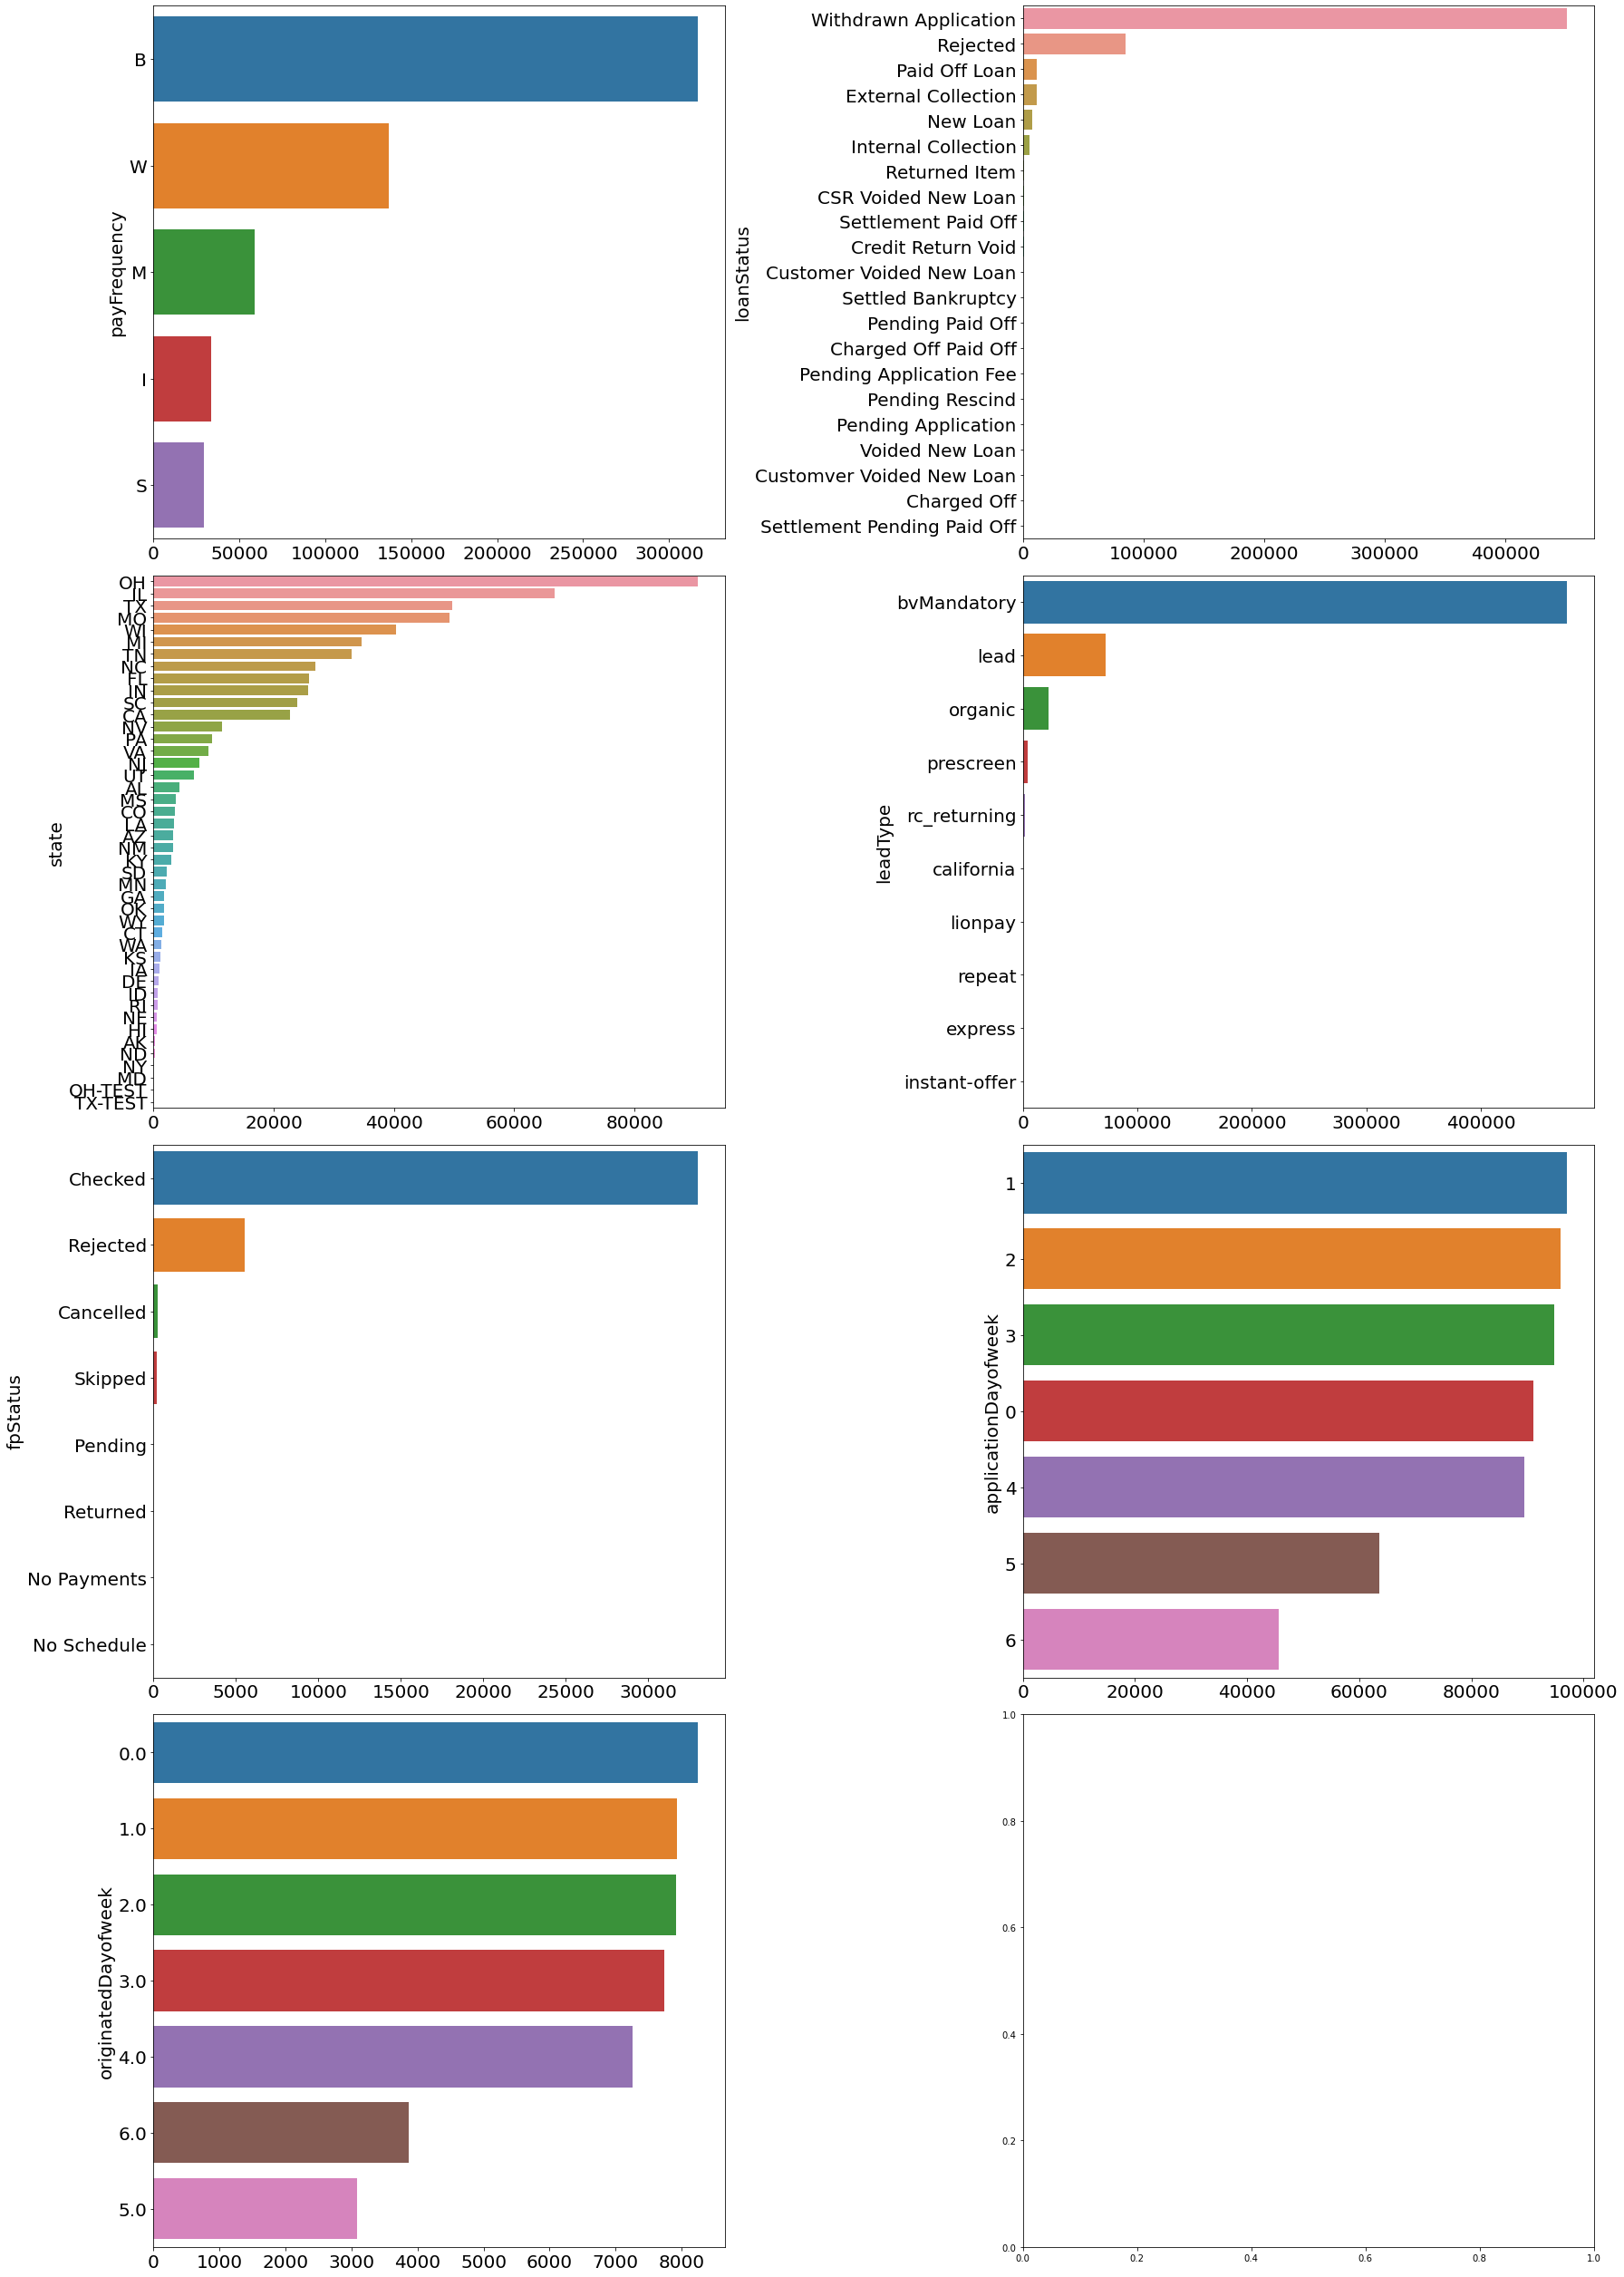

In [17]:
cat_cols = df_loan.select_dtypes(include=['category']).columns

#visulizing categorical data.
fig, ax = plt.subplots(math.ceil(len(cat_cols)/2) , 2, figsize=(25,35))

for index, col in enumerate(cat_cols):
    b = sns.countplot(y=col, data=df_loan, ax=ax[index//2, index%2], 
                  order = df_loan[col].value_counts().index)
    b.set_xlabel('', fontsize = 20.0) # X label
    b.set_ylabel(col, fontsize = 20.0) # Y label
    b.tick_params(labelsize=20)
#     else:
#         sns.histplot(df_loan[col], ax=ax[index//2, index%2]);
fig.tight_layout()
plt.show()

From the graphs, we can conclude that:
1. The most preferred payFrequency, is biweekly payments, followed byweekly, monthly, irregularly and semi monthly.
2. Majority of the loan is either withdrawn or Rejected (maybe we can target the possible customer that will have paid off loan.)
3. The states show the potential market that the campaign should target on/not. For example, reducing APR on states that has low applicants, or campaingn on already popular states to attract more potential customer in the area.
4. The most common way customer get in touch to loan is by ping tree with bank verification, followed by ping tree with optional bank verification, money lion website and direct email. Here, we can see that majority of the application of loan is generated through ping tree.
5. Majority of the first payment go are checked.
6. Dayofweek -> 0 = Monday, 6 = Sunday
    - Weekdays has the most applicants compared to weekends
    - Weekdays originated most, probably due to most application happens in the weekdays.

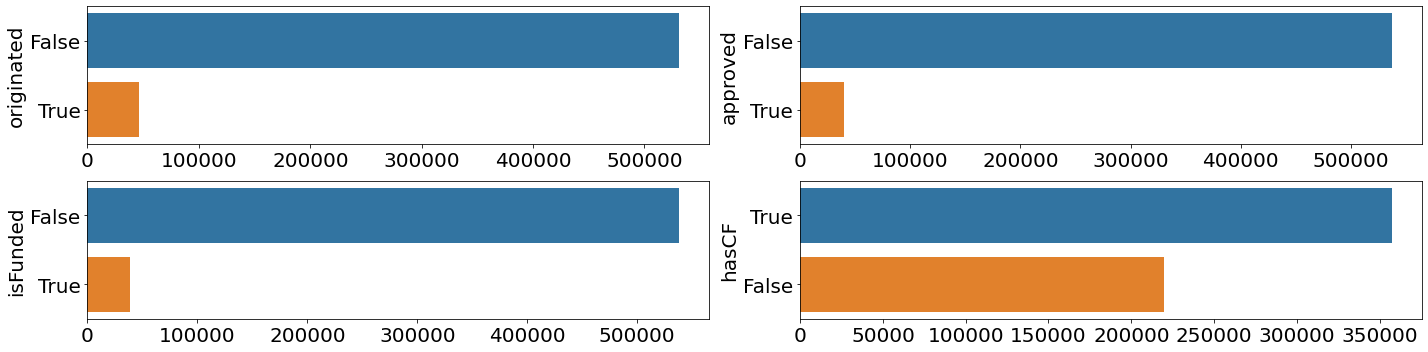

In [18]:
bool_cols = df_loan.select_dtypes(include=['bool']).columns

fig, ax = plt.subplots(math.ceil(len(bool_cols)/2) , 2, figsize=(20,5))

for index, col in enumerate(bool_cols):
    b = sns.countplot(y=col, data=df_loan, ax=ax[index//2, index%2], 
                  order = df_loan[col].value_counts().index)
    b.set_xlabel('', fontsize = 20.0) # X label
    b.set_ylabel(col, fontsize = 20.0) # Y label
    b.tick_params(labelsize=20)
#     else:
#         sns.histplot(df_loan[col], ax=ax[index//2, index%2]);
fig.tight_layout()
plt.show()

In [19]:
# ratio of number of application that are funded 
(df_loan['isFunded'].value_counts()[1] / (df_loan['isFunded'].value_counts()[0] + df_loan['isFunded'].value_counts()[1])) * 100

6.7494150633948315

From the calculation:
1. The ratio of number of application that are funded is roughly 6.75%

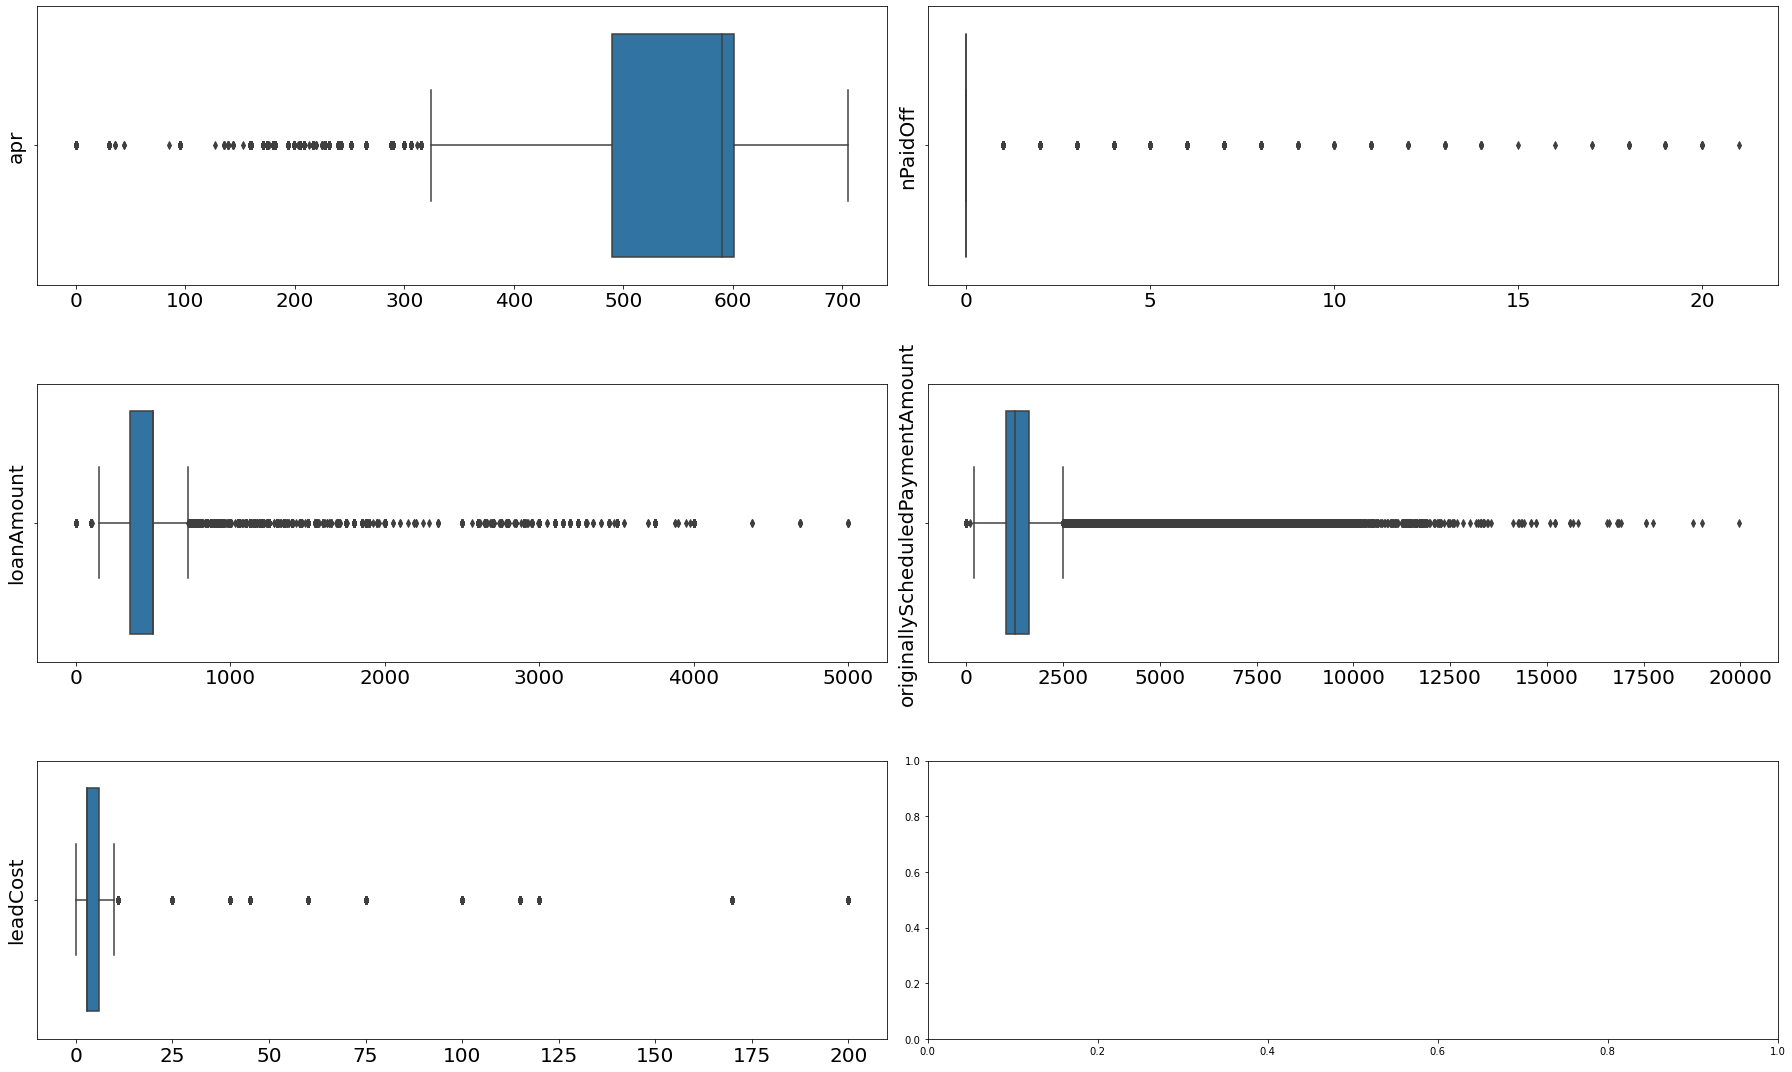

In [20]:
value_cols = ['apr' , 'nPaidOff', 'loanAmount', 'originallyScheduledPaymentAmount', 'leadCost']

#visulizing value data.
fig, ax = plt.subplots(math.ceil(len(value_cols)/2) , 2, figsize=(25,15))

for index, col in enumerate(value_cols):
    b = sns.boxplot(x=col, data=df_loan, ax=ax[index//2, index%2])
    b.set_xlabel('', fontsize = 20.0) # X label
    b.set_ylabel(col, fontsize = 20.0) # Y label
    b.tick_params(labelsize=20)
#     else:
#         sns.histplot(df_loan[col], ax=ax[index//2, index%2]);
fig.tight_layout()
plt.show()

In [21]:
df_loan['nPaidOff'].value_counts()

0.0     564341
1.0       8589
2.0       2599
3.0        918
4.0        427
5.0        212
6.0        133
7.0         56
8.0         26
11.0        16
9.0         15
13.0        10
10.0         9
12.0         8
14.0         8
19.0         7
18.0         6
20.0         5
17.0         2
15.0         1
21.0         1
16.0         1
Name: nPaidOff, dtype: int64

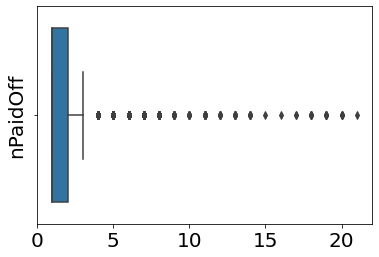

In [22]:
b = sns.boxplot(x='nPaidOff', data=df_loan[df_loan['nPaidOff'] != 0])
b.set_xlabel('', fontsize = 20.0) # X label
b.set_ylabel('nPaidOff', fontsize = 20.0) # Y label
b.tick_params(labelsize=20)
plt.show()

From the above graphs and calculations, we can see that:
1. The average APR rate of the data sets is around 500~600%
2. Most common number of paid off is 0.
3. The average loan amount is around 400~500
4. The average Schedule Payment is around 1000~1500 (distribution seems to sync with loan amount)

-------------------------------Application-----------------------------------------------Originated---------------------


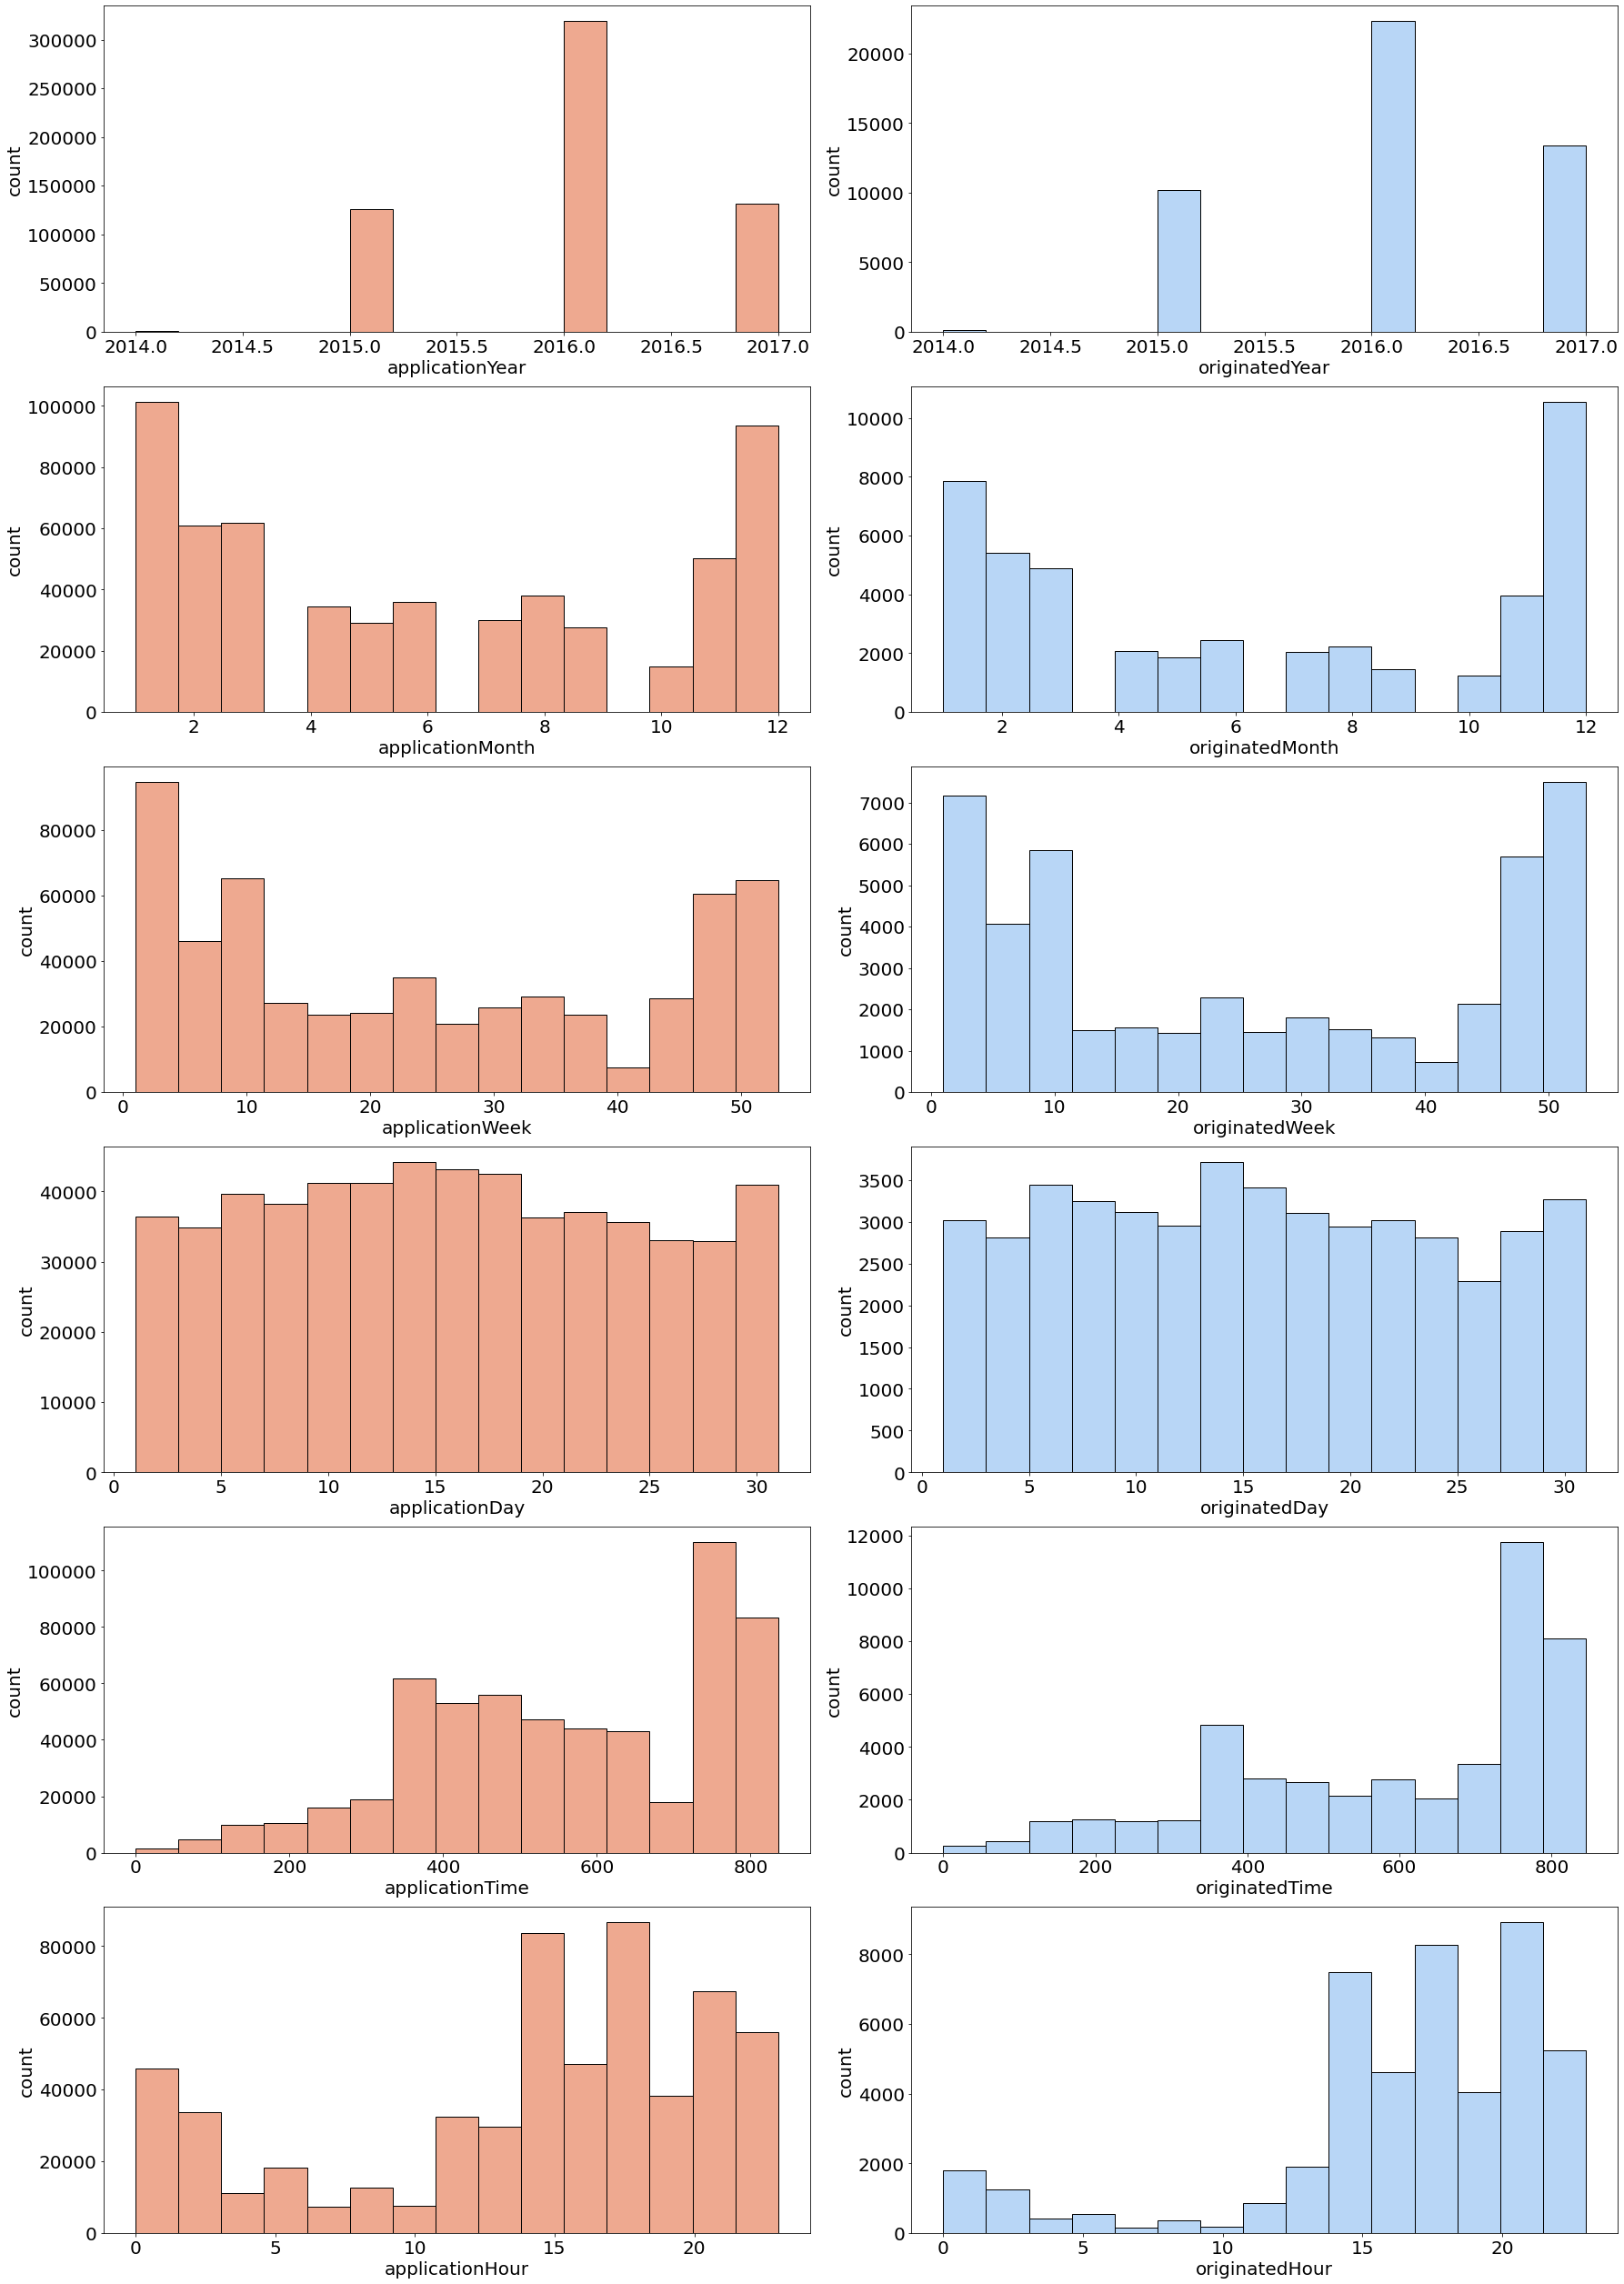

In [23]:
#visualizing date time data
time_cols = ['applicationYear', 'applicationMonth', 'applicationWeek', 'applicationDay', 
             'applicationTime', 'applicationHour', 'originatedYear', 'originatedMonth', 
             'originatedWeek', 'originatedDay','originatedTime', 'originatedHour']

#plot them side by side

#application --- originated
print('-------------------------------Application-----------------------------------------------Originated---------------------')
fig, ax = plt.subplots(math.ceil(len(time_cols)/2) , 2, figsize=(25,35))
for index, (col_a, col_o) in enumerate(zip(time_cols[:6], time_cols[6:])):
    sns.set_palette('flare')
    b = sns.histplot(x=col_a, data=df_loan, ax=ax[index, 0], bins=15)
    b.set_xlabel(col_a, fontsize = 20.0) # X label
    b.set_ylabel('count', fontsize = 20.0) # Y label
    b.tick_params(labelsize=20)
    

    sns.set_palette("pastel")
    c = sns.histplot(x=col_o, data=df_loan, ax=ax[index, 1], bins=15) #change colour here 
    c.set_xlabel(col_o, fontsize = 20.0) # X label
    c.set_ylabel('count', fontsize = 20.0) # Y label
    c.tick_params(labelsize=20)
    
fig.tight_layout()
plt.show()

From the graphs above:
1. Application date is almost identical to originated date.
2. Both application and originated date has the most at the beginning and the end of the month.
3. There's a sudden growth of loan application around 700-800 days (like between at end of 2016 to 2017).
4. the most application are applied between the evening and night.

## Visualizing distribution of each feature in df_payment

Here, I planned to groupby 'loanId' and observe how many users have actually paid at least once and the ratio between completed amount and paid amount. See whether it sync with 'fpStatus' in df_loan.

In [24]:
df_payment

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN
...,...,...,...,...,...,...,...,...,...
689359,LL-I-18629478,8,False,2017-07-14T04:00:00,45.62,17.67,63.29,None,NaN
689360,LL-I-18629478,9,False,2017-07-31T04:00:00,45.67,17.62,63.29,None,NaN
689361,LL-I-18629478,10,False,2017-08-15T04:00:00,51.12,12.17,63.29,None,NaN
689362,LL-I-18629478,11,False,2017-08-31T04:00:00,54.35,8.94,63.29,None,NaN


In [25]:
df_payment_2 = df_payment[(df_payment['paymentStatus'] == 'Checked')] #only checked will be consider.

In [26]:
#The reasons why I not choose columns because:
#1. payment amount is derived from principal and fees
#2. payment status is already filtered as 'Checked', and payment return code will not exist.
df_payment_2_grouped = df_payment_2.groupby(['loanId']).agg({'paymentAmount':'sum', 'isCollection':'max', 
                                                             'installmentIndex':'max', 'paymentDate': 'max'})

In [27]:
df_payment_2_grouped

,paymentAmount,isCollection,installmentIndex,paymentDate
loanId,,,,
LL-I-00000021,1865.61,True,12,2016-04-28T22:44:43.736000
LL-I-00000231,258.64,False,2,2014-12-26T05:00:00
LL-I-00000238,1162.60,False,7,2015-03-09T04:00:00
LL-I-00000308,61.59,False,1,2015-01-05T05:00:00
LL-I-00000419,226.31,False,3,2015-01-08T05:00:00
...,...,...,...,...
LP-I-00000109,1155.98,False,12,2016-07-15T04:00:00
LP-I-00000127,872.52,False,12,2016-07-29T04:00:00
LP-I-00000134,869.70,False,1,2016-02-24T14:16:50.404000


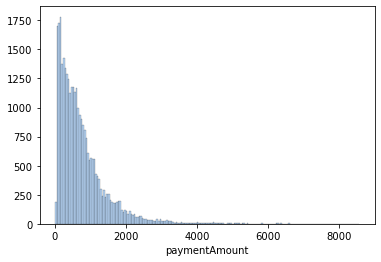

In [28]:
#visulizing paymentAmount.
b = sns.histplot(x='paymentAmount', data=df_payment_2_grouped)
b.set_xlabel('paymentAmount', fontsize = 10.0) # X label
b.set_ylabel('', fontsize = 10.0) # Y label
b.tick_params(labelsize=10)

plt.show()

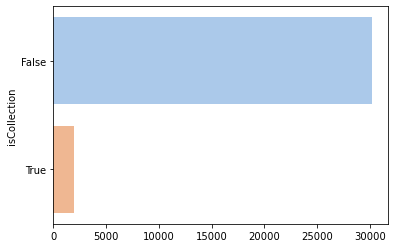

In [29]:
#visulizing is collection. It shows whether the customer has used custom made collection plan or not
b = sns.countplot(y='isCollection', data=df_payment_2_grouped)
b.set_xlabel('', fontsize = 10.0) # X label
b.set_ylabel('isCollection', fontsize = 10.0) # Y label
b.tick_params(labelsize=10)

plt.show()

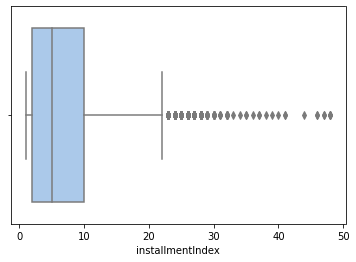

In [30]:
#visulizing installmentIndex. 
#This shows the max num of installment index for the customers (how many times they actually pay)

b = sns.boxplot(x='installmentIndex', data=df_payment_2_grouped)
b.set_xlabel('installmentIndex', fontsize = 10.0) # X label
# b.set_ylabel('count', fontsize = 10.0) # Y label
b.tick_params(labelsize=10)

plt.show()

## Visualizing df_clarity_var

- Fraud score provided by clarity. Higher score suggests lower default probability. (The higher the better)

In my opinion, I feel like only clearfraudscore is useful, in my case.

In [31]:
df_clarity_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                  49750 non-null  float64
 1   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                             49750 non-null  float64
 2   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                   49750 non-null  float64
 3   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                     49750 non-null  float64
 4   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                  49750

In [32]:
df_clarity_var_2 = df_clarity_var[['clearfraudscore', 'underwritingid']]
#remove score that is null
df_clarity_var_cleaned = df_clarity_var_2[~(df_clarity_var_2['clearfraudscore'].isnull())]

In [33]:
df_clarity_var_cleaned

,clearfraudscore,underwritingid
0,871.0,54cbffcee4b0ba763e43144d
1,397.0,54cc0408e4b0418d9a7f78af
2,572.0,54cc0683e4b0418d9a80adb6
3,838.0,54cc0780e4b0ba763e43b74a
4,768.0,54cc1d67e4b0ba763e445b45
...,...,...
49747,677.0,58cc5706e4b0b0437e26b19c
49748,640.0,58cc5763e4b0b0437e272d38
49749,576.0,58cc57d4e4b0b0437e278bff
49750,830.0,58cc5916e4b0b0437e2b6e07


## Merge all df

In [34]:
# df_loan, df_payment_2_grouped, df_clarity_var_cleaned

In [35]:
df_temp = pd.merge(df_loan, df_payment_2_grouped, on='loanId', how='left')

In [36]:
df_master= pd.merge(df_temp, df_clarity_var_cleaned, left_on='clarityFraudId', right_on='underwritingid', how='left')

In [37]:
df_master.describe()

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,applicationYear,applicationMonth,applicationWeek,applicationDay,applicationHour,applicationTime,originatedYear,originatedMonth,originatedWeek,originatedDay,originatedHour,originatedTime,paymentAmount,installmentIndex,clearfraudscore
count,573747.000000,577390.000000,575419.000000,577413.000000,577413.000000,577413.000000,577413.000000,577413.000000,577413.000000,577413.00000,577413.000000,46032.000000,46032.000000,46032.000000,46032.000000,46032.000000,46032.000000,32167.000000,32167.000000,36213.00000
mean,553.083270,0.037883,514.246622,1429.543410,7.854511,2016.007402,6.043982,24.621817,15.361031,14.01201,564.525632,2016.064151,6.380409,26.166971,15.241223,16.360532,595.426638,752.514912,6.719309,687.43338
std,110.042368,0.333396,320.942130,924.725741,12.852548,0.672199,4.059300,17.834430,8.516454,6.65546,191.743557,0.721343,4.306932,18.903037,8.586825,5.353528,208.821702,726.263449,6.096370,127.02735
min,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.000000,1.000000,1.000000,0.00000,0.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.010000,1.000000,122.00000
25%,490.000000,0.000000,350.000000,1023.780000,3.000000,2016.000000,2.000000,8.000000,8.000000,11.00000,409.000000,2016.000000,2.000000,8.000000,8.000000,15.000000,408.000000,266.675000,2.000000,596.00000
50%,590.000000,0.000000,500.000000,1245.260000,3.000000,2016.000000,6.000000,22.000000,15.000000,16.00000,568.000000,2016.000000,6.000000,24.000000,15.000000,17.000000,687.000000,565.210000,5.000000,696.00000
75%,601.000000,0.000000,500.000000,1615.660000,6.000000,2016.000000,10.000000,45.000000,22.000000,19.00000,747.000000,2017.000000,11.000000,48.000000,22.000000,20.000000,770.000000,988.175000,10.000000,787.00000
max,705.590000,21.000000,5000.000000,19963.630000,200.000000,2017.000000,12.000000,53.000000,31.000000,23.00000,836.000000,2017.000000,12.000000,53.000000,31.000000,23.000000,845.000000,8556.580000,48.000000,965.00000


In [38]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577413 entries, 0 to 577412
Data columns (total 39 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   loanId                            577413 non-null  object        
 1   anon_ssn                          577413 non-null  object        
 2   payFrequency                      576143 non-null  category      
 3   apr                               573747 non-null  float64       
 4   applicationDate                   577413 non-null  datetime64[ns]
 5   originated                        577413 non-null  bool          
 6   originatedDate                    46032 non-null   datetime64[ns]
 7   nPaidOff                          577390 non-null  float64       
 8   approved                          577413 non-null  bool          
 9   isFunded                          577413 non-null  bool          
 10  loanStatus                      

In [39]:
#fixing dtypes
df_master['isCollection'] = df_master['isCollection'].astype('bool')
df_master['paymentDate'] = df_master['paymentDate'].astype('datetime64[ns]')

In [40]:
df_master

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,applicationYear,applicationMonth,applicationWeek,applicationDay,applicationDayofweek,applicationHour,applicationTime,originatedYear,originatedMonth,originatedWeek,originatedDay,originatedDayofweek,originatedHour,originatedTime,paymentAmount,isCollection,installmentIndex,paymentDate,clearfraudscore,underwritingid
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,False,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,True,2016,2,8,23,1,17,447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,True,2016,1,3,19,1,22,412,2016.0,1.0,3.0,20.0,2.0,15.0,413.0,6287.08,False,22.0,2016-11-03 21:05:51.026,879.0,569eb3a3e4b096699f685d64
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,False,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,True,2016,8,31,1,0,13,607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,False,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,True,2015,8,32,6,3,23,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,False,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,True,2016,6,22,5,6,22,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577408,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,2016-11-08 17:32:33.554,False,NaT,0.0,False,False,Withdrawn Application,400.0,1292.41,NV,bvMandatory,3,NaN,58220cdde4b051c58d919c1f,True,2016,11,45,8,1,17,706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN
577409,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,2017-01-24 22:20:59.818,False,NaT,0.0,False,False,Withdrawn Application,1000.0,2592.39,MO,lead,25,NaN,5887d349e4b08f249ac45e2f,True,2017,1,4,24,1,22,783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN
577410,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,2016-02-02 03:05:47.797,False,NaT,0.0,False,False,Withdrawn Application,300.0,844.75,IN,bvMandatory,6,NaN,550b1f59e4b0d4592e28c84e,True,2016,2,5,2,1,3,426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN
577411,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,2015-05-21 20:19:49.639,False,NaT,0.0,False,False,Withdrawn Application,300.0,770.80,OH,organic,6,NaN,NaN,False,2015,5,21,21,3,20,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaT,NaN,NaN


## Main Idea

The motive of this analysis is to assess the risk of the applicants (Whether the applicant will repay the loan). Hence, I think that the target feature should be related to the motive, which are loanStatus (Defaulted or not) or fpStatus (Has pay for the first payment or not). However, it is possible too for the applicant for not paying full (result in loss). Hence, only loanStatus shall be referred. I will try to simplify the loanStatus to either paid off or defaulted the loan.


### Relationship
1. To find out how each features may possible related to each other.
    - Do more graphs and analysis to confirm the relationship and gain more insights.

### Modelling

The modelling has 1 main purpose:
1. Determine whether the applicant should be funded based on whether the funded applicant will pay or default after funded.
    - I believe there's a system of evaluation (some formulae) before the funds approved. 
    - In my opinion, before the funds is approved, expert system can be used to helps in the evaluation, then tune accordingly using the data in the future to know the results for the decision.
    - The model I proposed here is to use features that can be obtain mainly before it is originated/approved/funded to evaluate whether the applicant able to pay off or not in the future. The training dataset will only contains funded applicants, since we cannot know that the not funded applicant will repay the loan or not.

### Constraints

- In the dataset, it shows almost nothing about the background of the applicants (except fraud score).
    - I think this piece of information is the key to build a better model to predict the risk of the applicants.

## Data Pre-Process

The plan is:
1. Summarize the loanStatus (our target) into binary classes: Paidoff or Defaulted.
    - Loan that is funded and repaid: ['Paid Off Loan', 'Settlement Paid Off', 'Returned Item'] 
    - Ongoing Loan: ['External Collection', 'New Loan', 'Internal Collection Item', 'Pending Paid Off', 'Settlement Pending Paid Off'] 
    - Loan that is funded and defaulted: ['Settled Bankruptcy', 'Charged Off Paid Off', 'Charged Off']

ps: I think returned Item still acceptable since only 1 payment is missed.

In [41]:
df_funded = df_master[df_master['isFunded'] == True]
df_funded['loanStatus'].value_counts()

Paid Off Loan                  11427
External Collection            11325
New Loan                        8111
Internal Collection             5564
Returned Item                   1182
Settlement Paid Off              708
Settled Bankruptcy               325
Pending Paid Off                 169
Charged Off Paid Off             159
Settlement Pending Paid Off        1
Charged Off                        1
CSR Voided New Loan                0
Rejected                           0
Voided New Loan                    0
Pending Application                0
Pending Rescind                    0
Pending Application Fee            0
Customver Voided New Loan          0
Customer Voided New Loan           0
Credit Return Void                 0
Withdrawn Application              0
Name: loanStatus, dtype: int64

In [42]:
df_final = df_funded.copy()
df_final['loanStatus'] = df_final['loanStatus'].astype('object')
for index, row in enumerate(df_final['loanStatus']):
    desc = df_final['loanStatus'].iloc[index]
    if desc in ['Paid Off Loan', 'Settlement Paid Off', 'Returned Item']:
        df_final['loanStatus'].iloc[index] = 'Paid Off Loan'
    elif desc in ['Settled Bankruptcy', 'Charged Off Paid Off', 'Charged Off']:
        df_final['loanStatus'].iloc[index] = 'Defaulted Loan'
    else:
        df_final['loanStatus'].iloc[index] = 'Not Related'
        
df_final = df_final[df_final['loanStatus'] != 'Not Related']
df_final['loanStatus'] = df_final['loanStatus'].astype('category')

In [43]:
df_final['loanStatus'].value_counts()

Paid Off Loan     13317
Defaulted Loan      485
Name: loanStatus, dtype: int64

In [44]:
check_df(df_final)

nPaidOff: null=7, dtypes=float64
clarityFraudId: null=2711, dtypes=object
paymentAmount: null=638, dtypes=float64
installmentIndex: null=638, dtypes=float64
paymentDate: null=638, dtypes=datetime64[ns]
clearfraudscore: null=2767, dtypes=float64
underwritingid: null=2767, dtypes=object


In [45]:
df_final.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF',
       'applicationYear', 'applicationMonth', 'applicationWeek',
       'applicationDay', 'applicationDayofweek', 'applicationHour',
       'applicationTime', 'originatedYear', 'originatedMonth',
       'originatedWeek', 'originatedDay', 'originatedDayofweek',
       'originatedHour', 'originatedTime', 'paymentAmount', 'isCollection',
       'installmentIndex', 'paymentDate', 'clearfraudscore', 'underwritingid'],
      dtype='object')

In [46]:
# df_final[df_final['anon_ssn'] == 'ffdf8cca26a3364a57dd42c55aa88b69'][['originallyScheduledPaymentAmount', 'paymentAmount']]
# df_final[['originallyScheduledPaymentAmount', 'paymentAmount']]

In [47]:
#lets clean up all unused features
if 'loanId' in df_final.columns or 'isFunded' in df_final.columns:
    df_final = df_final.drop(['loanId', 'anon_ssn', 'clarityFraudId', 'underwritingid'], axis=1) #ids
    df_final = df_final.drop(['originated', 'approved', 'isFunded'], axis=1)# all 1's
    df_final = df_final.reset_index(drop=True)

#clean up unused categories
cat_cols = df_final.select_dtypes(include=['category']).columns

for col in cat_cols:
    df_final[col] = df_final[col].cat.remove_unused_categories()

In [48]:
df_final

,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,applicationYear,applicationMonth,applicationWeek,applicationDay,applicationDayofweek,applicationHour,applicationTime,originatedYear,originatedMonth,originatedWeek,originatedDay,originatedDayofweek,originatedHour,originatedTime,paymentAmount,isCollection,installmentIndex,paymentDate,clearfraudscore
0,B,199.0,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,True,2016,1,3,19,1,22,412,2016.0,1.0,3.0,20.0,2.0,15.0,413.0,6287.08,False,22.0,2016-11-03 21:05:51.026,879.0
1,S,490.0,2017-01-31 17:48:17.381,2017-01-31 18:00:14.520,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,True,2017,1,5,31,1,17,790,2017.0,1.0,5.0,31.0,1.0,18.0,790.0,1333.75,False,1.0,2017-02-06 23:32:27.293,835.0
2,B,590.0,2016-08-27 09:08:05.442,2016-08-29 15:05:04.014,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,True,2016,8,34,27,5,9,633,2016.0,8.0,35.0,29.0,0.0,15.0,635.0,2432.08,False,13.0,2017-02-24 05:00:00.000,624.0
3,W,404.1,2016-05-25 03:05:18.849,2016-05-25 15:11:36.260,3.0,Paid Off Loan,300.0,422.64,WI,organic,0,Checked,True,2016,5,21,25,2,3,539,2016.0,5.0,21.0,25.0,2.0,15.0,539.0,395.94,False,6.0,2016-07-05 22:07:52.299,770.0
4,W,590.0,2015-05-26 17:02:27.312,2015-05-26 18:45:48.024,0.0,Paid Off Loan,300.0,896.87,MO,bvMandatory,6,Rejected,False,2015,5,22,26,1,17,174,2015.0,5.0,22.0,26.0,1.0,18.0,174.0,396.05,False,5.0,2015-06-26 19:08:17.532,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13797,M,180.2,2017-02-21 20:29:57.538,2017-02-21 20:45:06.563,0.0,Paid Off Loan,500.0,794.60,CO,lead,25,Rejected,True,2017,2,8,21,1,20,811,2017.0,2.0,8.0,21.0,1.0,20.0,811.0,NaN,True,NaN,NaT,695.0
13798,B,565.0,2016-12-01 16:57:49.231,2016-12-01 17:28:21.872,3.0,Paid Off Loan,600.0,1670.18,CA,rc_returning,0,Checked,False,2016,12,48,1,3,16,729,2016.0,12.0,48.0,1.0,3.0,17.0,729.0,895.06,False,4.0,2017-01-06 05:00:00.000,NaN
13799,M,645.0,2017-01-14 19:43:08.685,2017-01-14 20:00:10.426,0.0,Paid Off Loan,375.0,1042.40,AL,lead,25,Checked,True,2017,1,2,14,5,19,773,2017.0,1.0,2.0,14.0,5.0,20.0,773.0,461.29,False,1.0,2017-01-30 16:29:45.336,700.0
13800,B,449.0,2016-06-22 01:10:50.110,2016-06-22 21:46:54.359,0.0,Paid Off Loan,400.0,664.12,WI,lead,40,Checked,True,2016,6,25,22,2,1,567,2016.0,6.0,25.0,22.0,2.0,21.0,567.0,664.12,False,13.0,2016-12-15 05:00:00.000,806.0


## Features and Target Relationship

In [49]:
# sns.color_palette("deep")

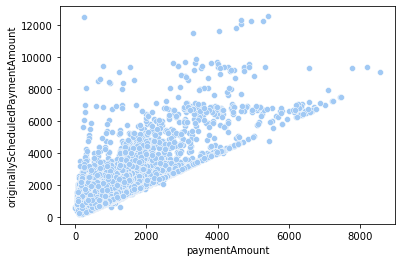

In [50]:
sns.scatterplot(df_final['paymentAmount'], df_final['originallyScheduledPaymentAmount'])

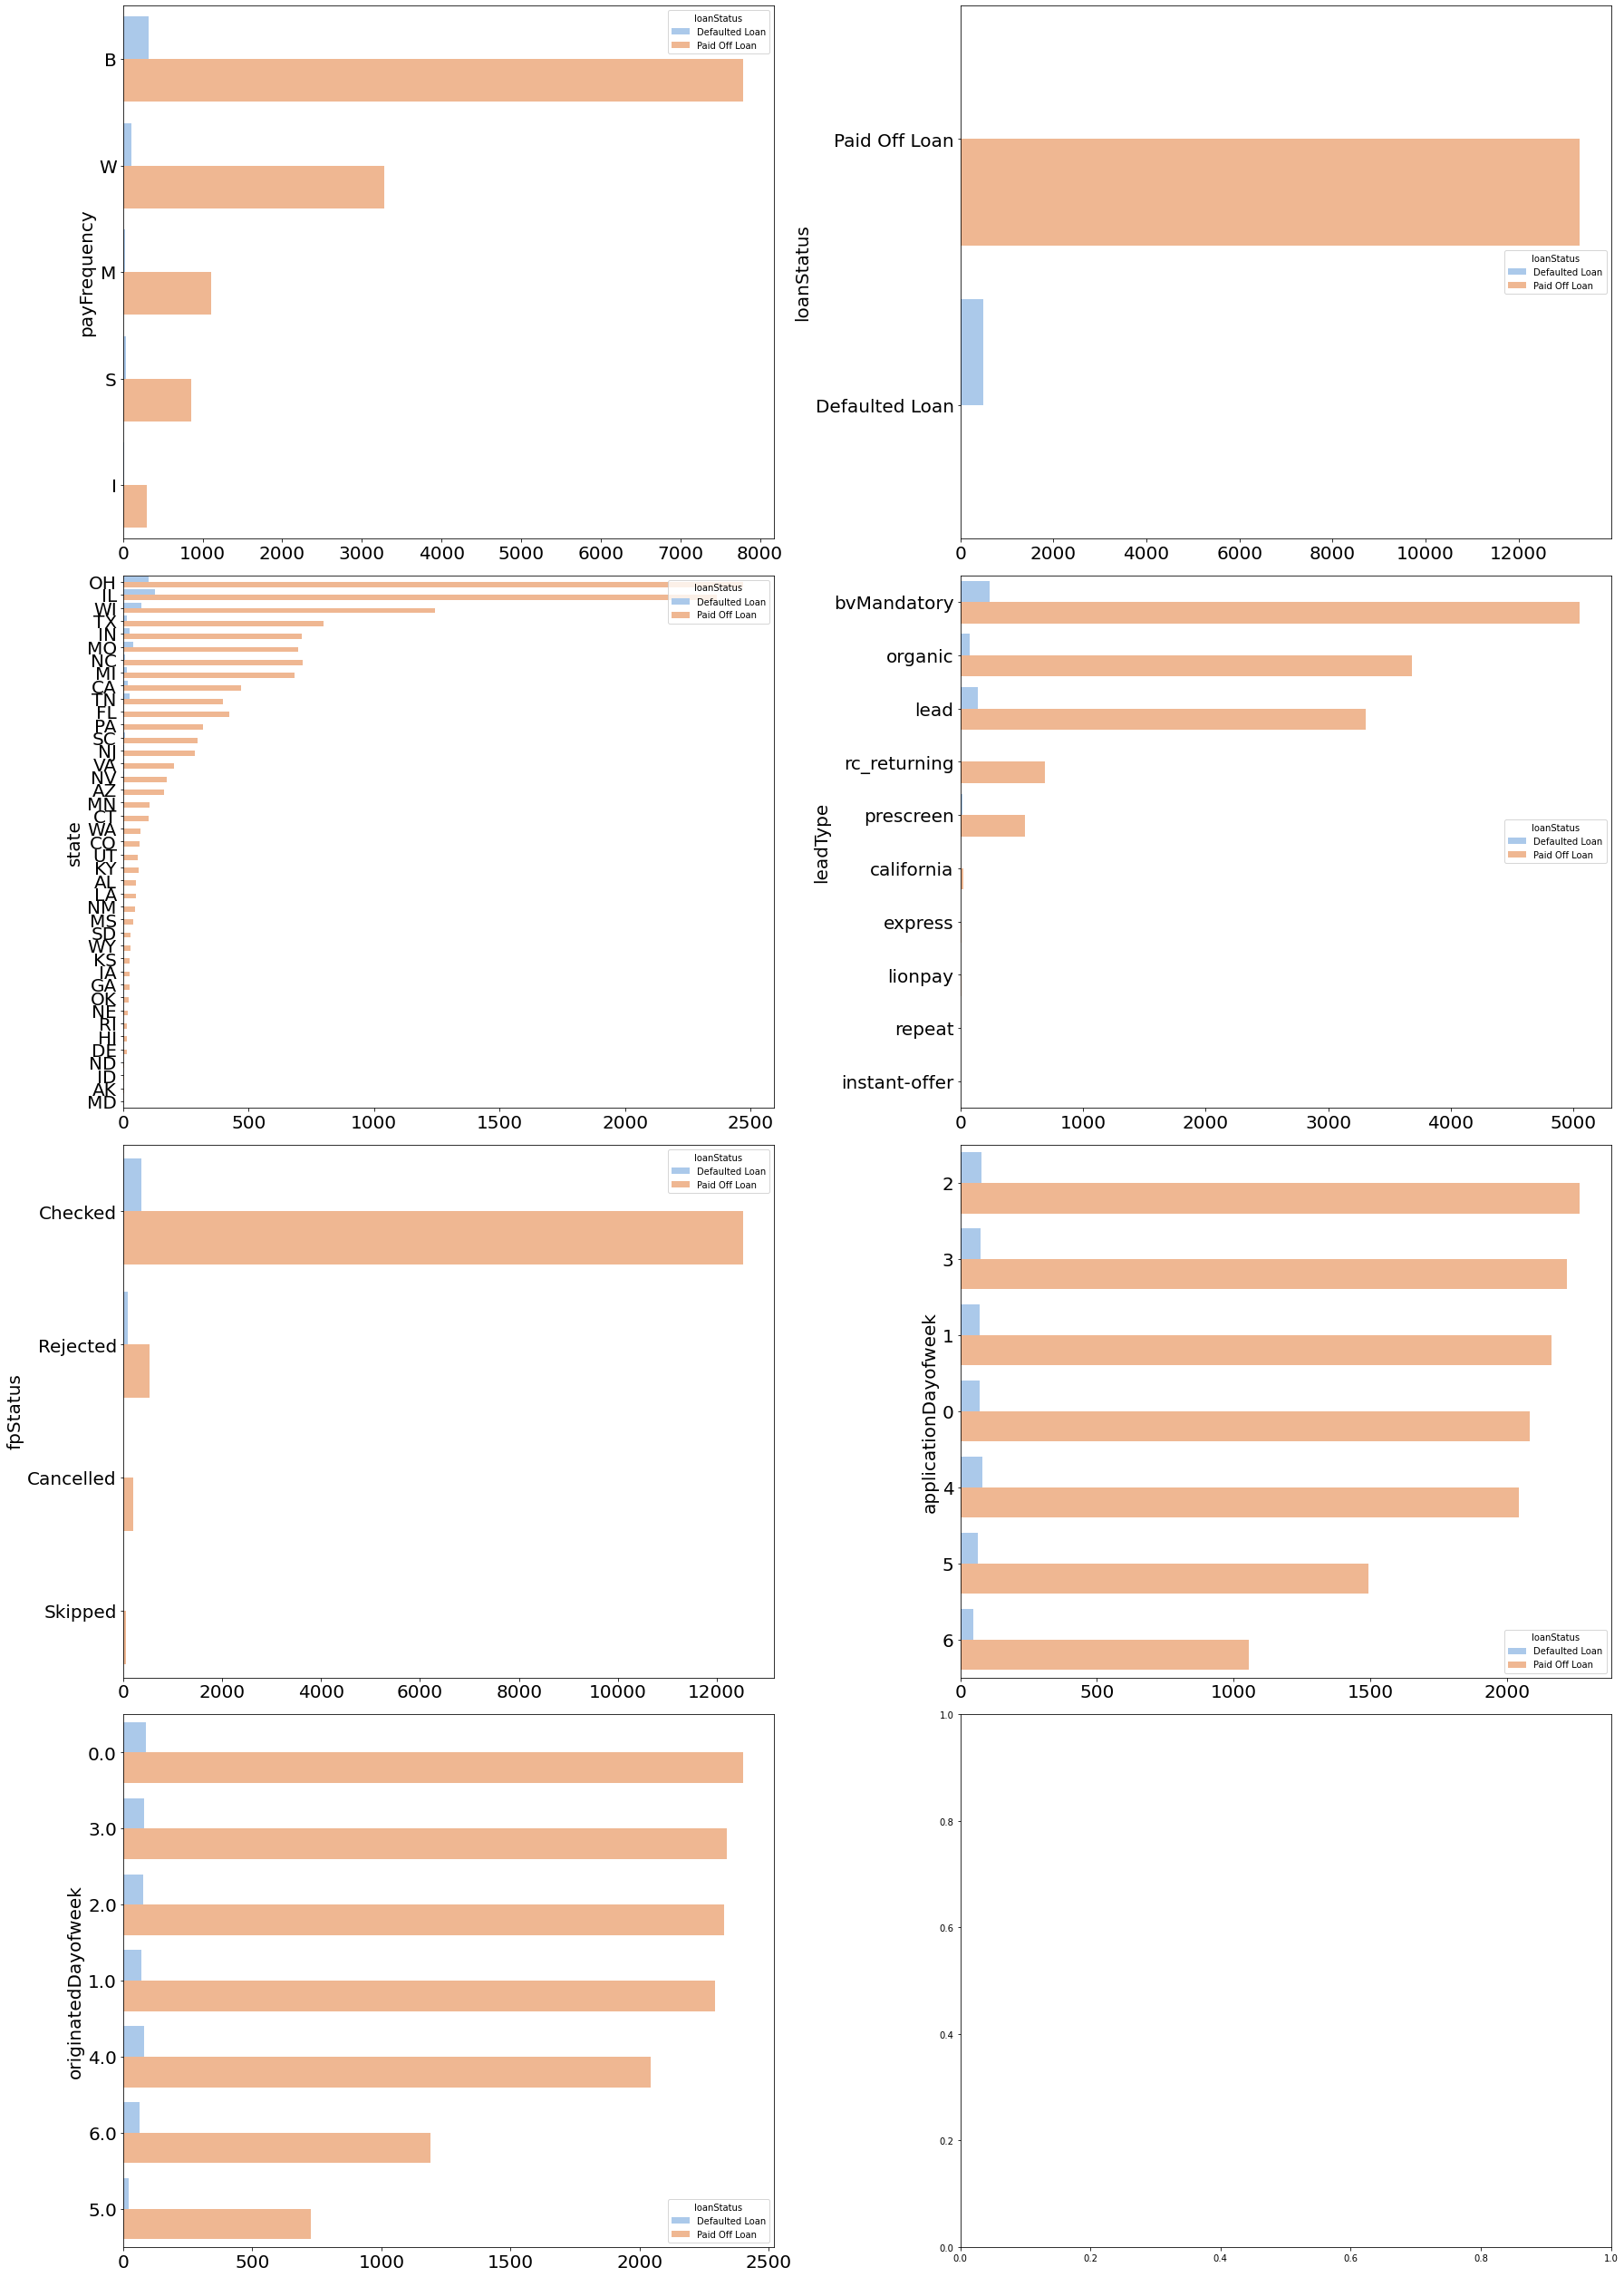

In [51]:
target = 'loanStatus'
cat_cols = df_final.select_dtypes(include=['category']).columns

#visulizing categorical data.
fig, ax = plt.subplots(math.ceil(len(cat_cols)/2) , 2, figsize=(25,35))

for index, col in enumerate(cat_cols):
    sns.set_palette("pastel")
    b = sns.countplot(y=col, data=df_final, ax=ax[index//2, index%2], 
                  order = df_final[col].value_counts().index, hue=target)
    b.set_xlabel('', fontsize = 20.0) # X label
    b.set_ylabel(col, fontsize = 20.0) # Y label
    b.tick_params(labelsize=20)

fig.tight_layout()
plt.show()

In [52]:
for col in cat_cols:
    if col == target:
        continue
    df_temp = df_final.pivot_table(index=col, columns=target, aggfunc='size')
    df_temp['Defaulted (%)'] = (df_temp['Defaulted Loan'] / (df_temp['Defaulted Loan'] + df_temp['Paid Off Loan']))*100
    display(df_temp.sort_values(by='Defaulted (%)', ascending=False))

loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
payFrequency,,,
B,318,7785,3.924472
S,31,855,3.498871
W,105,3277,3.104672
I,9,294,2.970297
M,22,1106,1.950355


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
state,,,
UT,6,59,9.230769
TN,25,399,5.896226
WI,74,1244,5.614568
MO,41,697,5.555556
IL,126,2366,5.056180
MS,2,42,4.545455
OH,102,2470,3.965785
KS,1,27,3.571429
IN,26,713,3.518268


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
leadType,,,
bvMandatory,239,5054,4.515398
lead,143,3308,4.143726
california,1,25,3.846154
prescreen,19,526,3.486239
organic,80,3685,2.124834
rc_returning,3,692,0.431655
express,0,10,0.000000
instant-offer,0,1,0.000000
lionpay,0,10,0.000000


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
fpStatus,,,
Rejected,98,528,15.654952
Skipped,8,63,11.267606
Cancelled,8,204,3.773585
Checked,371,12522,2.877530


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
applicationDayofweek,,,
6,47,1055,4.264973
5,65,1492,4.174695
4,80,2044,3.766478
2,77,2266,3.286385
0,70,2082,3.252788
3,74,2217,3.230031
1,72,2161,3.224362


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
originatedDayofweek,,,
6.0,63,1191,5.023923
4.0,82,2044,3.857008
0.0,88,2399,3.538400
3.0,82,2337,3.389831
2.0,77,2328,3.201663
1.0,71,2292,3.004655
5.0,22,726,2.941176


From the graph and tables:
1. The top 3 payfrequency that has highest percentange of defaulted loan are biweekly, semimonthly and weekly.
2. State UT has the highest default rate.
3. LeadType bvMandatory (ping tree) has the highest default rate.

In [53]:
bool_cols

Index(['originated', 'approved', 'isFunded', 'hasCF'], dtype='object')

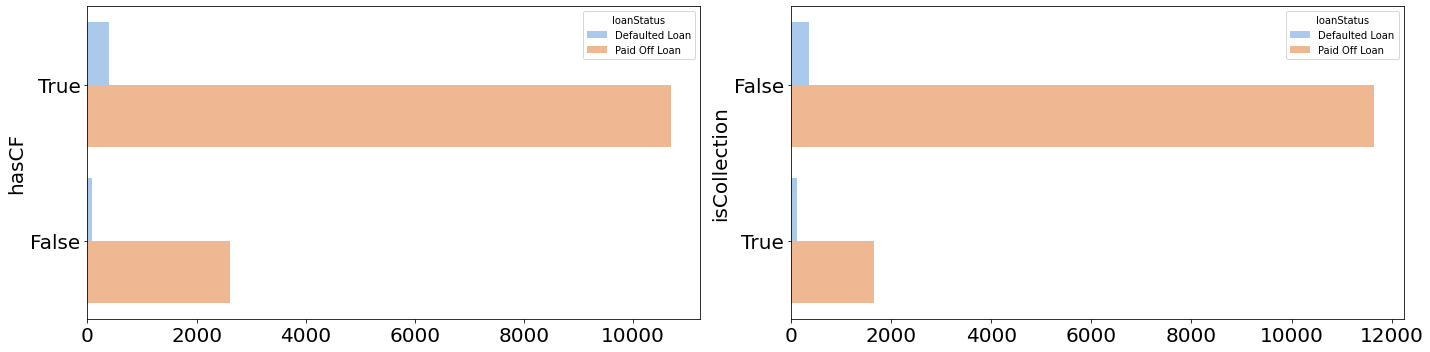

In [54]:
bool_cols = df_final.select_dtypes(include=['bool']).columns

#visulizing categorical data.
fig, ax = plt.subplots(1 , 2, figsize=(20,5))

for index, col in enumerate(bool_cols):
    b = sns.countplot(y=col, data=df_final, ax=ax[index%2], 
                  order = df_final[col].value_counts().index, hue=target)
    b.set_xlabel('', fontsize = 20.0) # X label
    b.set_ylabel(col, fontsize = 20.0) # Y label
    b.tick_params(labelsize=20)

fig.tight_layout()
plt.show()

In [55]:
for col in bool_cols:
    df_temp = df_final.pivot_table(index=col, columns=target, aggfunc='size')
    df_temp['Defaulted (%)'] = (df_temp['Defaulted Loan'] / (df_temp['Defaulted Loan'] + df_temp['Paid Off Loan']))*100
    display(df_temp.sort_values(by='Defaulted (%)', ascending=False))

loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
hasCF,,,
True,393,10698,3.543414
False,92,2619,3.393582


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
isCollection,,,
True,118,1663,6.625491
False,367,11654,3.052991


- Surprisingly, those customer with CF is more likely to default the loan
- From the table, customer with collection plan is more likely to default loan.


In [56]:
df_final.dtypes

payFrequency                              category
apr                                        float64
applicationDate                     datetime64[ns]
originatedDate                      datetime64[ns]
nPaidOff                                   float64
loanStatus                                category
loanAmount                                 float64
originallyScheduledPaymentAmount           float64
state                                     category
leadType                                  category
leadCost                                     int64
fpStatus                                  category
hasCF                                         bool
applicationYear                              int64
applicationMonth                             int64
applicationWeek                              int64
applicationDay                               int64
applicationDayofweek                      category
applicationHour                              int64
applicationTime                

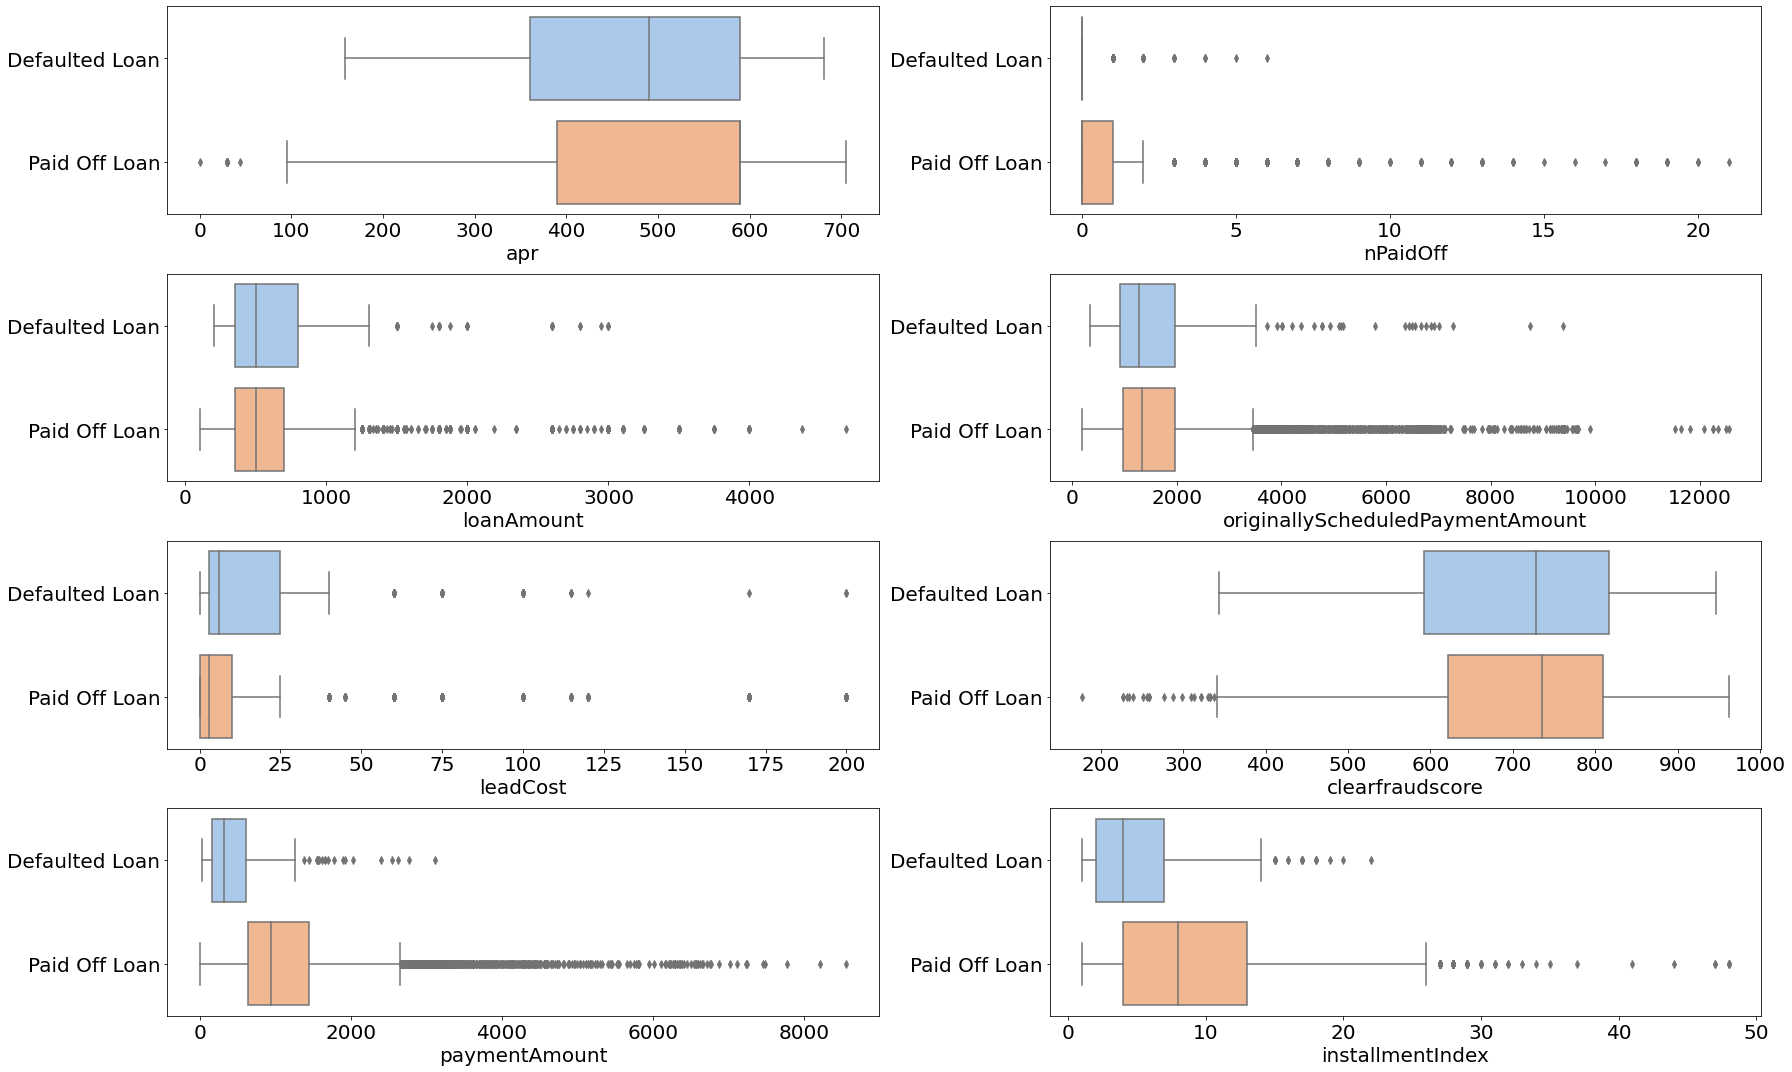

In [57]:
value_cols = ['apr' , 'nPaidOff', 'loanAmount', 'originallyScheduledPaymentAmount', 
              'leadCost', 'clearfraudscore', 'paymentAmount', 'installmentIndex']

#visulizing value data.
fig, ax = plt.subplots(math.ceil(len(value_cols)/2) , 2, figsize=(25,15))

for index, col in enumerate(value_cols):
    b = sns.boxplot(x=col, y=target, data=df_final, ax=ax[index//2, index%2])
    b.set_xlabel(col, fontsize = 20.0) # X label
    b.set_ylabel('', fontsize = 20.0) # Y label
    b.tick_params(labelsize=20)

fig.tight_layout()
plt.show()

In [58]:
df_temp = df_final.pivot_table(index=target, aggfunc='mean')[value_cols]
display(df_temp)

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,clearfraudscore,paymentAmount,installmentIndex
loanStatus,,,,,,,,
Defaulted Loan,484.717908,0.232990,649.043299,1665.791052,17.727835,702.392308,465.518153,4.788918
Paid Off Loan,512.284948,0.568971,632.402493,1681.410346,12.284824,711.578675,1151.569784,9.755260


In [59]:

((df_temp['leadCost']['Defaulted Loan'] - df_temp['leadCost']['Paid Off Loan'])/df_temp['leadCost']['Paid Off Loan'])*100

44.306790088720035

From the graph and table
- Clear Fraud Score is has slightly higher mean on paid off loan compared to defaulted loan.
- The leadcost for the default loan is 44.31% higher than paid off loan.
- Smaller paymentAmount tend to have more defaulted

-------------------------------Application----------------------------------------Originated---------------------


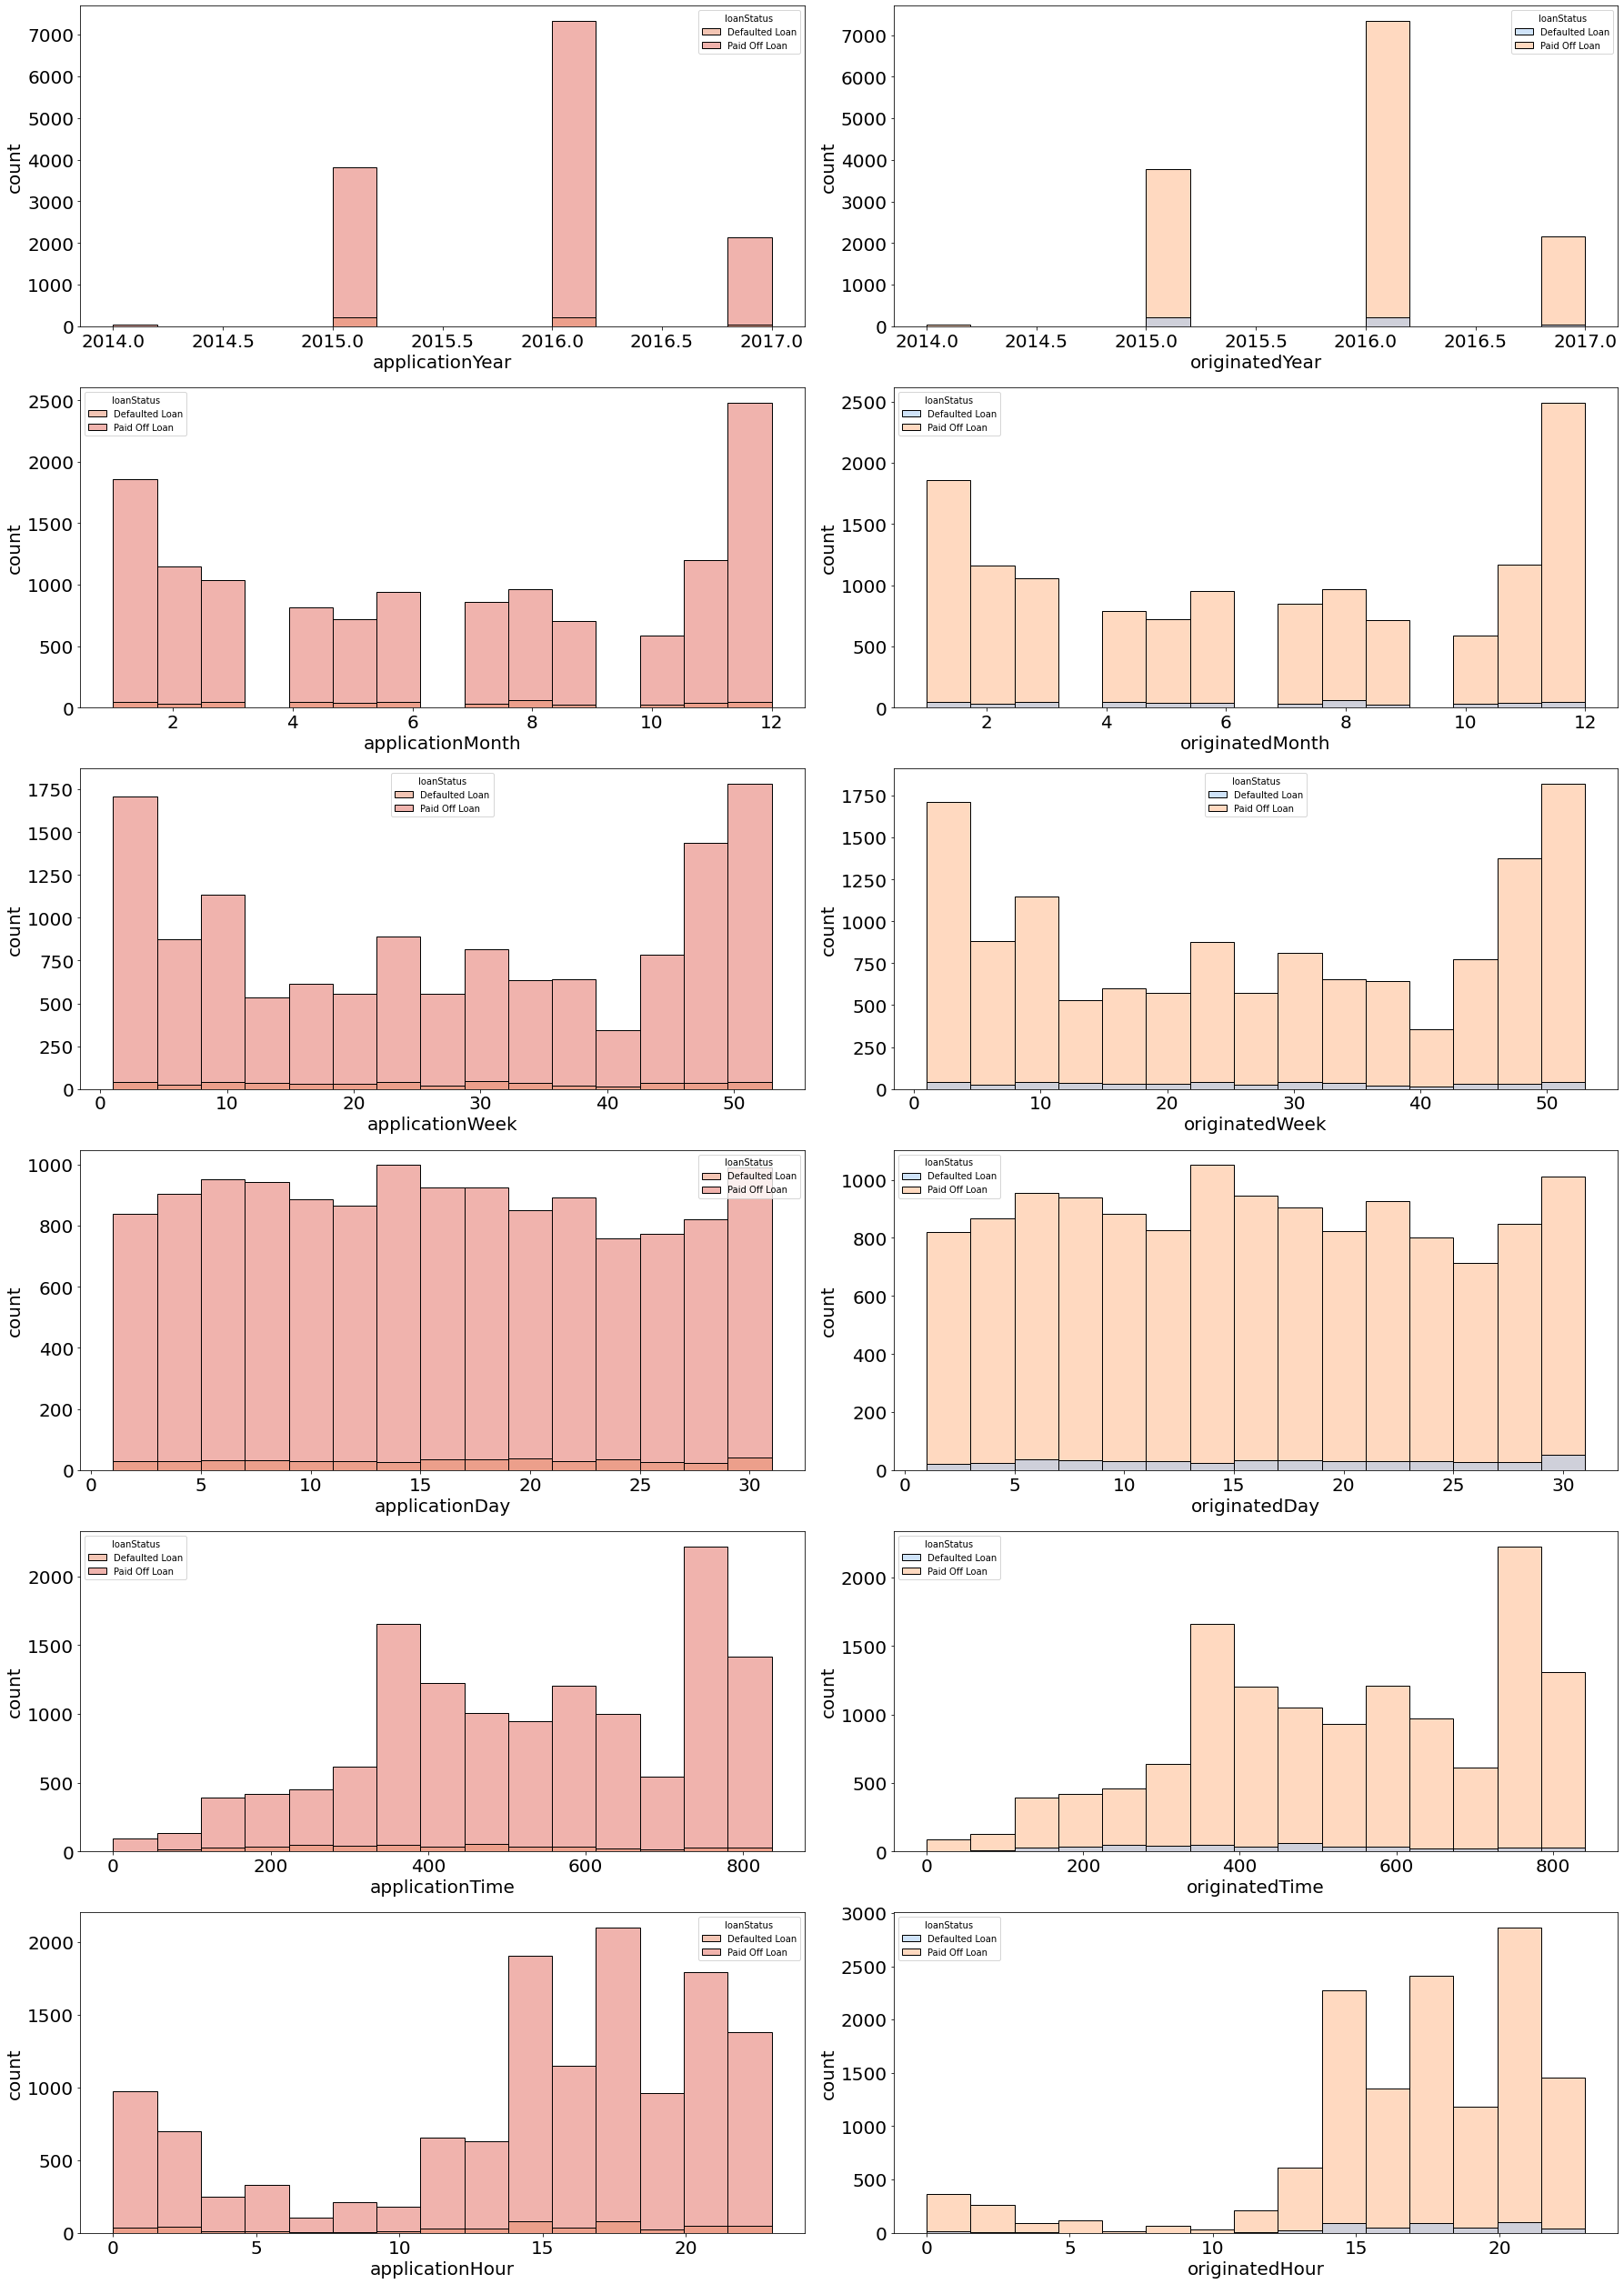

In [60]:
#visualizing date time data
time_cols = ['applicationYear', 'applicationMonth', 'applicationWeek', 'applicationDay', 
             'applicationTime', 'applicationHour', 'originatedYear', 'originatedMonth', 
             'originatedWeek', 'originatedDay','originatedTime', 'originatedHour']

#plot them side by side

#application --- originated
print('-------------------------------Application----------------------------------------Originated---------------------')
fig, ax = plt.subplots(math.ceil(len(time_cols)/2) , 2, figsize=(25,35))
for index, (col_a, col_o) in enumerate(zip(time_cols[:6], time_cols[6:])):
    sns.set_palette('flare')
    b = sns.histplot(x=col_a, data=df_final, ax=ax[index, 0], bins=15, hue=target)
    b.set_xlabel(col_a, fontsize = 20.0) # X label
    b.set_ylabel('count', fontsize = 20.0) # Y label
    b.tick_params(labelsize=20) 

    sns.set_palette("pastel")
    c = sns.histplot(x=col_o, data=df_final, ax=ax[index, 1], bins=15, hue=target) 
    c.set_xlabel(col_o, fontsize = 20.0) # X label
    c.set_ylabel('count', fontsize = 20.0) # Y label
    c.tick_params(labelsize=20)
    
fig.tight_layout()
plt.show()

In [61]:
for col in time_cols:
    if col == target:
        continue
    df_temp = df_final.pivot_table(index=col, columns=target, aggfunc='size')
    df_temp['Defaulted (%)'] = (df_temp['Defaulted Loan'] / (df_temp['Defaulted Loan'] + df_temp['Paid Off Loan']))*100
    display(df_temp.sort_values(by='Defaulted (%)', ascending=False))
#     df_temp['Defaulted (%)'] = (df_temp['Defaulted Loan'] / (df_temp['Defaulted Loan'] + df_temp['Paid Off Loan']))*100
#     display(df_temp)

loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
applicationYear,,,
2014,4,49,7.547170
2015,217,3809,5.389965
2016,222,7323,2.942346
2017,42,2136,1.928375


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
applicationMonth,,,
8,59,961,5.784314
5,42,718,5.526316
4,44,813,5.134189
10,28,584,4.575163
6,43,943,4.361055
3,46,1037,4.247461
7,30,862,3.363229
9,24,705,3.292181
11,40,1200,3.225806


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
applicationWeek,,,
12,12,142,7.792208
32,18,230,7.258065
31,13,176,6.878307
43,9,122,6.870229
20,14,199,6.572770
38,9,134,6.293706
13,12,191,5.911330
35,12,194,5.825243
25,13,221,5.555556


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
applicationDay,,,
23,21,421,4.751131
30,18,380,4.522613
20,21,448,4.477612
31,10,218,4.385965
19,18,401,4.295943
24,15,337,4.261364
16,20,456,4.201681
6,21,489,4.117647
26,17,400,4.076739


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
applicationTime,,,
209,2,1,66.666667
77,1,1,50.000000
87,1,1,50.000000
100,1,1,50.000000
101,1,1,50.000000
...,...,...,...
323,0,10,0.000000
326,0,6,0.000000
330,0,28,0.000000


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
applicationHour,,,
2,29,372,7.231920
11,13,241,5.118110
8,5,98,4.854369
10,9,179,4.787234
13,28,629,4.261796
17,48,1103,4.170287
14,37,854,4.152637
3,14,329,4.081633
1,18,432,4.000000


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
originatedYear,,,
2014.0,3,47,6.000000
2015.0,216,3784,5.400000
2016.0,224,7335,2.963355
2017.0,42,2151,1.915185


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
originatedMonth,,,
8.0,58,971,5.636540
5.0,42,726,5.468750
4.0,44,791,5.269461
10.0,29,588,4.700162
6.0,43,955,4.308617
3.0,47,1055,4.264973
7.0,31,846,3.534778
11.0,40,1165,3.319502
9.0,23,713,3.125000


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
originatedWeek,,,
12.0,13,131,9.027778
32.0,17,207,7.589286
15.0,13,193,6.310680
20.0,13,195,6.250000
38.0,8,123,6.106870
40.0,8,130,5.797101
43.0,8,130,5.797101
31.0,12,196,5.769231
21.0,13,214,5.726872


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
originatedDay,,,
31.0,19,227,7.723577
10.0,22,410,5.092593
6.0,26,493,5.009634
25.0,19,365,4.947917
29.0,21,404,4.941176
23.0,23,464,4.722793
7.0,22,478,4.400000
20.0,20,440,4.347826
16.0,21,463,4.338843


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
originatedTime,,,
444.0,1,0,100.000000
179.0,2,1,66.666667
185.0,1,1,50.000000
556.0,1,1,50.000000
84.0,1,1,50.000000
...,...,...,...
353.0,0,8,0.000000
350.0,0,24,0.000000
347.0,0,23,0.000000


loanStatus,Defaulted Loan,Paid Off Loan,Defaulted (%)
originatedHour,,,
7.0,1,18,5.263158
3.0,6,111,5.128205
19.0,53,1187,4.274194
1.0,7,161,4.166667
15.0,52,1217,4.097715
14.0,44,1057,3.996367
13.0,24,610,3.785489
20.0,55,1408,3.759398
11.0,2,52,3.703704


From the table, we can observe that the rate of defaulted has decrease since 2014 to 2017, from ~7% to ~2%

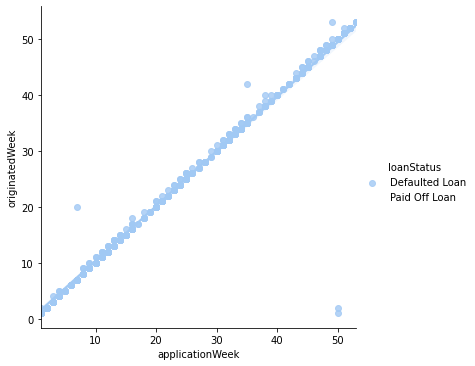

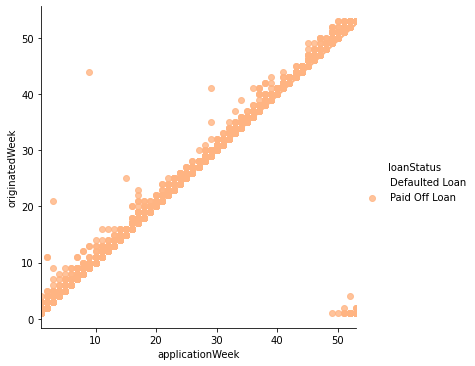

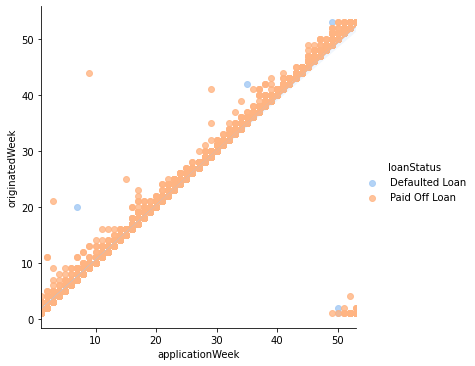

In [62]:
sns.lmplot("applicationWeek", "originatedWeek", data=df_final[df_final['loanStatus']=='Defaulted Loan'], hue=target)
sns.lmplot("applicationWeek", "originatedWeek", data=df_final[df_final['loanStatus']=='Paid Off Loan'], hue=target)
sns.lmplot("applicationWeek", "originatedWeek", data=df_final, hue=target)

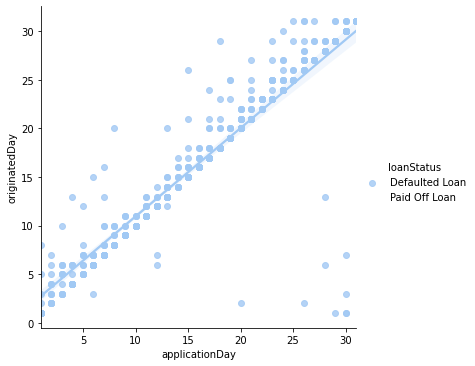

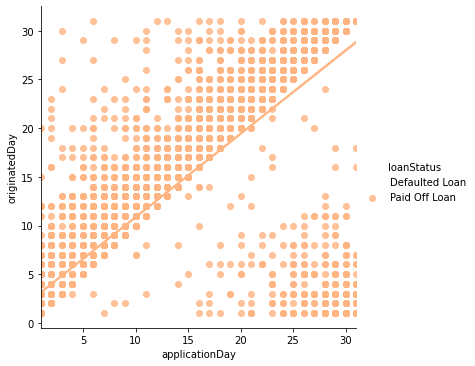

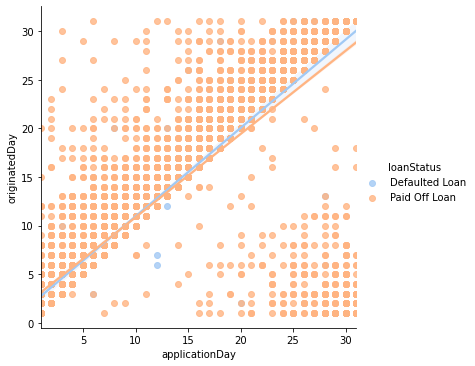

In [63]:
sns.lmplot("applicationDay", "originatedDay", data=df_final[df_final['loanStatus']=='Defaulted Loan'], hue=target)
sns.lmplot("applicationDay", "originatedDay", data=df_final[df_final['loanStatus']=='Paid Off Loan'], hue=target)
sns.lmplot("applicationDay", "originatedDay", data=df_final, hue=target)

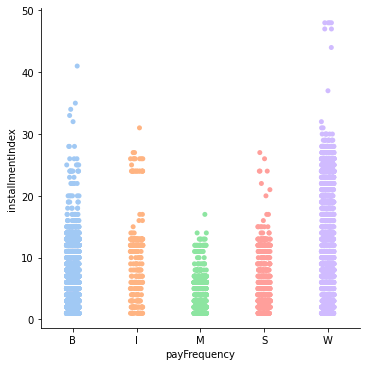

In [64]:
sns.catplot(x="payFrequency", y="installmentIndex", data=df_final)
# M > S > I > B > W

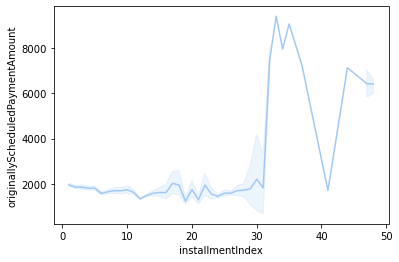

In [65]:
#prove that installmentIndex has nothing to do with scheduled payment amount.
#this is because most of the high amount is paid earlier.
sns.lineplot(x="installmentIndex", y="originallyScheduledPaymentAmount",  data=df_final)

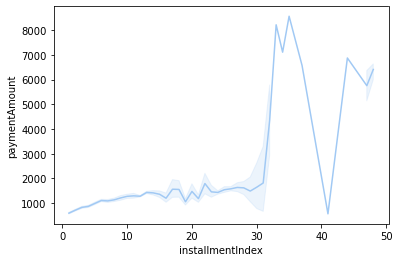

In [66]:
sns.lineplot(x="installmentIndex", y="paymentAmount",  data=df_final)

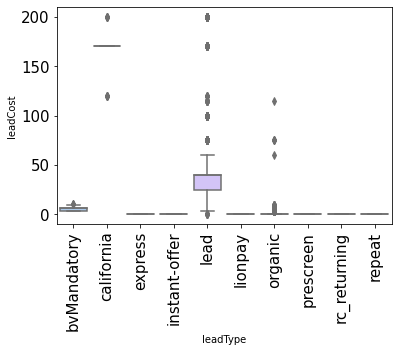

In [67]:
bp = sns.boxplot(x="leadType", y="leadCost",  data=df_final)    
bp.tick_params(labelsize=15) 
plt.setp(bp.get_xticklabels(), rotation=90)
plt.show()

### Summary regarding the relationship between target and features. (Which I think have insights)
1. State UT has the highest default rate.
2. Defaulted loan mainly came from biweekly and weekly pay method.
- Surprisingly, those customer with CF is more likely to default the loan.
- Customer with collection plan is more likely to default loan.
- Clear Fraud Score has slightly higher mean on paid off loan compared to defaulted loan.
- The leadcost for the default loan is 44.31% higher than paid off loan.
- The rate of defaulted has decrease since 2014 to 2017, from ~7% to ~2%
- Smaller paymentAmount tend to have more defaulted.
- Installment index increase when the pay is more frequent.
- Installment index and payment amount is not proportional.

In [68]:
check_df(df_final)

nPaidOff: null=7, dtypes=float64
paymentAmount: null=638, dtypes=float64
installmentIndex: null=638, dtypes=float64
paymentDate: null=638, dtypes=datetime64[ns]
clearfraudscore: null=2767, dtypes=float64


In [69]:
df_final.columns

Index(['payFrequency', 'apr', 'applicationDate', 'originatedDate', 'nPaidOff',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'hasCF', 'applicationYear',
       'applicationMonth', 'applicationWeek', 'applicationDay',
       'applicationDayofweek', 'applicationHour', 'applicationTime',
       'originatedYear', 'originatedMonth', 'originatedWeek', 'originatedDay',
       'originatedDayofweek', 'originatedHour', 'originatedTime',
       'paymentAmount', 'isCollection', 'installmentIndex', 'paymentDate',
       'clearfraudscore'],
      dtype='object')

## Impute missing values / drop missing values

- imputed clearfraudscore with 0
- imputed installmentindex based on mean, groupby payfreq
- imputed paymentAmount with scheduledAmount
- imputed nPaidOff with 0

In [70]:
df_imputed = df_final.copy()

#fill clearfraudscore as 0
df_imputed['clearfraudscore'] = df_imputed['clearfraudscore'].fillna(0)

#impute installmentindex based on mean, groupby payFreq 
## I choose mean here because it is more logical, since when payFreq inc, the index increase too.
### mean is better than median (the gap can be observed)
temp_dict = dict(df_imputed.groupby('payFrequency').mean()['installmentIndex']) #use mean to impute null of installmentindex
df_imputed['installment_index_mean_based_payf'] = df_imputed['payFrequency'].map(temp_dict)
df_imputed['installmentIndex'] = df_imputed.apply(
    lambda df: round(df['installment_index_mean_based_payf']) if np.isnan(df['installmentIndex']) else df['installmentIndex'],
    axis=1
)# this function takes in df, and return either install_mean_based or installindex.
df_imputed = df_imputed.drop('installment_index_mean_based_payf', axis=1)

#Tried to use KNN, but seems pointless as im only referring to payFreq

# from sklearn.impute import KNNImputer
# from sklearn import preprocessing
# knn_imputer = KNNImputer(n_neighbors=50) #based on the catplot above, pick only 50 points around the cat to cal.
# df_imputed_knn = df_final.copy()
# encoder = preprocessing.LabelEncoder() #encode payfreq
# df_imputed_knn['encodedPayFrequency'] = encoder.fit_transform(df_imputed_knn['payFrequency'])
# X = pd.concat([df_imputed_knn['encodedPayFrequency'], df_imputed_knn['installmentIndex'], df_imputed_knn['originallyScheduledPaymentAmount']], axis=1)
# temp =  knn_imputer.fit_transform(X)
# df_imputed_knn['installmentIndexImputed'] = [i[1] for i in temp]

#make unknown payamount = scheduled amount
df_imputed['paymentAmount'] = df_imputed['paymentAmount'].fillna(df_imputed['originallyScheduledPaymentAmount'])

#make unknown paidoff = 0 
df_imputed['nPaidOff'] = df_imputed['nPaidOff'].fillna(0)

In [71]:
check_df(df_imputed)

paymentDate: null=638, dtypes=datetime64[ns]


In [72]:
df_imputed.columns

Index(['payFrequency', 'apr', 'applicationDate', 'originatedDate', 'nPaidOff',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'hasCF', 'applicationYear',
       'applicationMonth', 'applicationWeek', 'applicationDay',
       'applicationDayofweek', 'applicationHour', 'applicationTime',
       'originatedYear', 'originatedMonth', 'originatedWeek', 'originatedDay',
       'originatedDayofweek', 'originatedHour', 'originatedTime',
       'paymentAmount', 'isCollection', 'installmentIndex', 'paymentDate',
       'clearfraudscore'],
      dtype='object')

## Feature Engineering / Selections

engineer:
1. scheduledamount/loanamount = ratio of earnings. (quite similar to APR)
2. paymentamount/scheduledamount = ratio of paid (future)
3. paymentamount - loanamount = how much customer spent. (or earn if bankrupt) (future)
4. timetaken = originatedTime - applicationTime
5. duration_of_pay = paymentTime - originatedTime

In [73]:
#encoding all possible cats
df_encoded = df_imputed.copy()

#M > S > I > B > W
pf_dict = dict([['M', 0], ['S', 1], ['I', 2], ['B', 3], ['W', 4]])
df_encoded['payFrequency'] = (df_encoded['payFrequency'].map(pf_dict)).astype('int32')

#defaultedloan = 1
ls_dict = dict([['Paid Off Loan', 0], ['Defaulted Loan', 1]])
df_encoded['loanStatus'] = (df_encoded['loanStatus'].map(ls_dict)).astype('int32')

#has Collection = 1
ls_dict = dict([[False, 0], [True, 1]])
df_encoded['isCollection'] = (df_encoded['isCollection'].map(ls_dict)).astype('int32')

In [74]:
#when performs 1-hot-encoding, there's too much states and leadtype. 
#reduce leadtype (<=26)
leadtype_to_drop = [i[0] for i in df_encoded['leadType'].value_counts().items() if i[1]<=26]
df_encoded['leadType'] = (df_encoded.apply(lambda df: 'other' if df['leadType'] in leadtype_to_drop 
                                          else df['leadType'],axis=1)).astype('category')
#reduce states (<=30)
states_to_drop = [i[0] for i in df_encoded['state'].value_counts().items() if i[1]<=30]
df_encoded['state'] = (df_encoded.apply(lambda df: 'other' if df['state'] in states_to_drop 
                                        else df['state'],axis=1)).astype('category')

In [75]:
#engineer
df_encoded['earning_ratio'] = df_encoded['originallyScheduledPaymentAmount'] / df_encoded['loanAmount']
df_encoded['time_taken'] = df_encoded['originatedTime'] - df_encoded['applicationTime']
df_encoded['duration_of_pay'] = (df_encoded['paymentDate'].dt.date - df_loan['applicationDate'].dt.date.min()).apply(lambda x: x.days) - df_encoded['originatedTime']

In [76]:
df_encoded.dtypes

payFrequency                                 int32
apr                                        float64
applicationDate                     datetime64[ns]
originatedDate                      datetime64[ns]
nPaidOff                                   float64
loanStatus                                   int32
loanAmount                                 float64
originallyScheduledPaymentAmount           float64
state                                     category
leadType                                  category
leadCost                                     int64
fpStatus                                  category
hasCF                                         bool
applicationYear                              int64
applicationMonth                             int64
applicationWeek                              int64
applicationDay                               int64
applicationDayofweek                      category
applicationHour                              int64
applicationTime                

In [77]:
time_cols = df_encoded.filter(regex='originated|Year|Month|Hour|Time', axis=1).columns
# time_cols = df_encoded.filter(regex='application', axis=1).columns

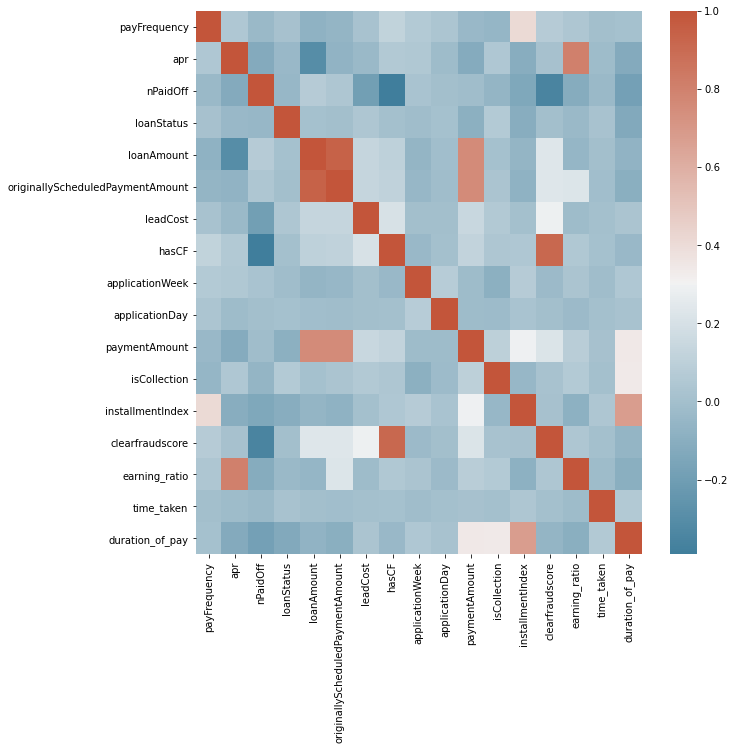

In [78]:
#correlation graph
f, ax = plt.subplots(figsize=(10,10))
corr = df_encoded.drop(time_cols, axis=1).corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap)

#From the correlation graph:
#1. Removed Highly Correlated features with non-target
#2. Understand that none of the features has high correlation with target.

In [79]:
df_encoded.describe()

,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,applicationYear,applicationMonth,applicationWeek,applicationDay,applicationHour,applicationTime,originatedYear,originatedMonth,originatedWeek,originatedDay,originatedHour,originatedTime,paymentAmount,isCollection,installmentIndex,clearfraudscore,earning_ratio,time_taken,duration_of_pay
count,13802.000000,13802.000000,13802.000000,13802.00000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000,13164.000000
mean,2.849515,511.316246,0.556876,0.03514,632.987248,1680.861487,12.476090,2015.858426,6.648747,27.322707,15.362629,14.522895,528.438777,2015.861832,6.640414,27.286698,15.462397,16.800464,529.528039,1178.690714,0.129039,9.543762,568.663092,2.674846,1.089262,115.299985
std,1.112094,119.584548,1.346925,0.18414,450.471573,1206.973028,24.250406,0.666970,3.976337,17.465908,8.670084,6.537088,201.636804,0.666435,3.974835,17.459464,8.653164,4.804025,201.247749,891.455439,0.335256,7.061214,306.980818,0.530634,3.829040,77.209990
min,0.000000,0.000000,0.000000,0.00000,100.000000,188.410000,0.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,3.000000,390.000000,0.000000,0.00000,350.000000,970.102500,0.000000,2015.000000,3.000000,10.000000,8.000000,12.000000,375.000000,2015.000000,3.000000,10.000000,8.000000,15.000000,376.000000,632.492500,0.000000,4.000000,496.000000,2.198170,0.000000,46.000000
50%,3.000000,590.000000,0.000000,0.00000,500.000000,1329.390000,3.000000,2016.000000,7.000000,27.000000,15.000000,16.000000,541.000000,2016.000000,7.000000,27.000000,15.000000,18.000000,542.000000,952.800000,0.000000,8.000000,679.000000,2.788700,0.000000,120.000000
75%,3.000000,590.000000,1.000000,0.00000,700.000000,1965.222500,10.000000,2016.000000,11.000000,46.000000,23.000000,19.000000,731.000000,2016.000000,11.000000,46.000000,23.000000,20.000000,732.000000,1472.452500,0.000000,13.000000,792.000000,3.069132,1.000000,173.000000
max,4.000000,705.590000,21.000000,1.00000,4687.000000,12550.080000,200.000000,2017.000000,12.000000,53.000000,31.000000,23.000000,836.000000,2017.000000,12.000000,53.000000,31.000000,23.000000,841.000000,9644.690000,1.000000,48.000000,962.000000,7.299911,245.000000,609.000000


## Model Training
1. to use:
    - payFrequency, apr, nPaidOff, loanAmount, leadCost, appweek, appday, 
    - state, leadType, clearfraudscore, earning_ratio, time_taken,
    - loanStatus (target)

2. no use:
    - future inaccessible such as installmentIndex, iscollection
    - IDs
    - hasCF (as there is clearfraudscore)
    - paymentamount&scheduledamount (i keep loan amount as it's more logic)
    - Duration of pay (involved payment, so its future feature too)
    - All originated time & date
    - All application time & date except: applicationWeek(0-53),Day

In [80]:
df_train = df_encoded[['payFrequency', 'apr', 'nPaidOff', 'loanAmount', 'leadCost', 
                       'applicationWeek', 'applicationDay', 'state', 'leadType', 
                       'clearfraudscore', 'earning_ratio', 'time_taken', 'loanStatus']] 

In [81]:
df_train

,payFrequency,apr,nPaidOff,loanAmount,leadCost,applicationWeek,applicationDay,state,leadType,clearfraudscore,earning_ratio,time_taken,loanStatus
0,3,199.0,0.0,3000.0,0,3,19,CA,prescreen,879.0,2.131730,1.0,0
1,1,490.0,2.0,1250.0,0,5,31,MO,organic,835.0,2.651024,0.0,0
2,3,590.0,0.0,800.0,10,34,27,CA,bvMandatory,624.0,3.040100,2.0,0
3,4,404.1,3.0,300.0,0,21,25,WI,organic,770.0,1.408800,0.0,0
4,4,590.0,0.0,300.0,6,22,26,MO,bvMandatory,0.0,2.989567,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13797,0,180.2,0.0,500.0,25,8,21,CO,lead,695.0,1.589200,0.0,0
13798,3,565.0,3.0,600.0,0,48,1,CA,rc_returning,0.0,2.783633,0.0,0
13799,0,645.0,0.0,375.0,25,2,14,AL,lead,700.0,2.779733,0.0,0
13800,3,449.0,0.0,400.0,40,25,22,WI,lead,806.0,1.660300,0.0,0


In [82]:
#onehot encoding
df_train = pd.get_dummies(df_train, drop_first=True)

In [83]:
df_train

,payFrequency,apr,nPaidOff,loanAmount,leadCost,applicationWeek,applicationDay,clearfraudscore,earning_ratio,time_taken,loanStatus,state_AZ,state_CA,state_CO,state_CT,state_FL,state_IL,state_IN,state_KY,state_LA,state_MI,state_MN,state_MO,state_MS,state_NC,state_NJ,state_NM,state_NV,state_OH,state_PA,state_SC,state_TN,state_TX,state_UT,state_VA,state_WA,state_WI,state_other,leadType_lead,leadType_organic,leadType_other,leadType_prescreen,leadType_rc_returning
0,3,199.0,0.0,3000.0,0,3,19,879.0,2.131730,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,490.0,2.0,1250.0,0,5,31,835.0,2.651024,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3,590.0,0.0,800.0,10,34,27,624.0,3.040100,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,404.1,3.0,300.0,0,21,25,770.0,1.408800,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,4,590.0,0.0,300.0,6,22,26,0.0,2.989567,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13797,0,180.2,0.0,500.0,25,8,21,695.0,1.589200,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13798,3,565.0,3.0,600.0,0,48,1,0.0,2.783633,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13799,0,645.0,0.0,375.0,25,2,14,700.0,2.779733,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13800,3,449.0,0.0,400.0,40,25,22,806.0,1.660300,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [84]:
df_train.columns

Index(['payFrequency', 'apr', 'nPaidOff', 'loanAmount', 'leadCost',
       'applicationWeek', 'applicationDay', 'clearfraudscore', 'earning_ratio',
       'time_taken', 'loanStatus', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_FL', 'state_IL', 'state_IN', 'state_KY', 'state_LA',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_NC', 'state_NJ',
       'state_NM', 'state_NV', 'state_OH', 'state_PA', 'state_SC', 'state_TN',
       'state_TX', 'state_UT', 'state_VA', 'state_WA', 'state_WI',
       'state_other', 'leadType_lead', 'leadType_organic', 'leadType_other',
       'leadType_prescreen', 'leadType_rc_returning'],
      dtype='object')

**AUCROC:**
1. a popular diagnostic tool for classifiers on balanced and imbalanced binary prediction problems alike because it is not biased to the majority or minority class.
2.     ROC analysis does not have any bias toward models that perform well on the minority class at the expense of the majority class—a property that is quite attractive when dealing with imbalanced data. — Page 27, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.
3.     Although ROC graphs are widely used to evaluate classifiers under presence of class imbalance, it has a drawback: under class rarity, that is, when the problem of class imbalance is associated to the presence of a low sample size of minority instances, as the estimates can be unreliable. — Page 55, Learning from Imbalanced Data Sets, 2018.
4. ROC looks at "what would happen if I change this threshold to all possible values"

### Summary (clear)

1. AUC ROC / F1:
    - high AUC ROC vs low f1 or other "point" metric, means that your classifier currently does a bad job, however you can find the threshold for which its score is actually pretty decent
    - low AUC ROC and low f1 or other "point" metric, means that your classifier currently does a bad job, and even fitting a threshold will not change it
    - high AUC ROC and high f1 or other "point" metric, means that your classifier currently does a decent job, and for many other values of threshold it would do the same
    - low AUC ROC vs high f1 or other "point" metric, means that your classifier currently does a decent job, however for many other values of threshold - it is pretty bad


2. Precision / Recall
    - precision - how much you should trust the robot when it says it found defaulted loan
    - recall = how much the model can find defaulted loan.

    - precision is important to prevent the loss of potential customer
    - Recall is also important so that it can prevent moneylion to get more defaulted loan and loss money

    - try to find a balance between them using F1
    
3. Macro / Micro
    - micro - TP/(TP+FP) of each class, then sum (for class imbalance)
    - macro - sum of TP / (sum of TP +FP)
    
- For reducing False Negative -> maximize recall/ sensitivity (minimizing False negative)


## Pycaret

In [85]:
data = df_train.sample(frac=0.8, random_state=786) #for train + Valid
data_unseen = df_train.drop(data.index) #for test set

In [86]:
# data['loanStatus'].value_counts()
# data_unseen['loanStatus'].value_counts()

In [87]:
#pycaret - feature selection -> better, PCA ->worse
exp_clf101 = setup(data = data, target = 'loanStatus',session_id=123, 
                   numeric_features=['leadCost'], fix_imbalance=True, feature_selection=True) 

,Description,Value
0,session_id,123
1,Target,loanStatus
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(11042, 43)"
5,Missing Values,False
6,Numeric Features,42
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [88]:
get_config('y_test').value_counts()
# get_config('y_train').value_counts()
# get_config('y').value_counts()

0    3194
1     119
Name: loanStatus, dtype: int64

In [89]:
compare_models(sort = 'F1') #cross validated results based on the training set (70%)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8506,0.6493,0.2905,0.0794,0.1239,0.0714,0.0895,0.2870
gbc,Gradient Boosting Classifier,0.9105,0.6583,0.1431,0.0821,0.1034,0.0605,0.0633,0.8780
lr,Logistic Regression,0.7432,0.6333,0.4049,0.0585,0.1022,0.0418,0.0693,1.1490
lda,Linear Discriminant Analysis,0.8207,0.6601,0.2754,0.0624,0.1017,0.0453,0.0602,0.0630
ridge,Ridge Classifier,0.8203,0.0000,0.2754,0.0623,0.1015,0.0451,0.0600,0.0310
nb,Naive Bayes,0.4667,0.6489,0.7601,0.0498,0.0934,0.0275,0.0809,0.0300
knn,K Neighbors Classifier,0.7847,0.5706,0.2911,0.0520,0.0882,0.0289,0.0435,0.1210
qda,Quadratic Discriminant Analysis,0.3244,0.5983,0.8779,0.0452,0.0860,0.0186,0.0743,0.0460
et,Extra Trees Classifier,0.9508,0.6403,0.0501,0.1044,0.0672,0.0459,0.0491,0.4160
dt,Decision Tree Classifier,0.9093,0.5060,0.0714,0.0447,0.0548,0.0104,0.0105,0.0650


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)

In [90]:
ada = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8538,0.7064,0.2500,0.0707,0.1102,0.0570,0.0707
1,0.8784,0.6185,0.1786,0.0658,0.0962,0.0456,0.0523
2,0.8448,0.6258,0.3571,0.0893,0.1429,0.0901,0.1169
3,0.8693,0.6926,0.2857,0.0899,0.1368,0.0864,0.1036
4,0.8525,0.7110,0.3214,0.0865,0.1364,0.0841,0.1062
5,0.8383,0.5725,0.2857,0.0708,0.1135,0.0588,0.0766
6,0.8254,0.6266,0.1786,0.0427,0.0690,0.0112,0.0147
7,0.8396,0.6639,0.3929,0.0932,0.1507,0.0979,0.1295
8,0.8875,0.6378,0.3214,0.1169,0.1714,0.1249,0.1436
9,0.8161,0.6383,0.3333,0.0677,0.1125,0.0577,0.0812


In [91]:
tuned_ada = tune_model(ada, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8370,0.7008,0.2143,0.0545,0.0870,0.0310,0.0399
1,0.8525,0.6661,0.1429,0.0426,0.0656,0.0103,0.0126
2,0.8266,0.6374,0.2857,0.0656,0.1067,0.0507,0.0680
3,0.8499,0.7271,0.2857,0.0769,0.1212,0.0680,0.0859
4,0.8435,0.7178,0.3571,0.0885,0.1418,0.0889,0.1158
5,0.8292,0.5997,0.2500,0.0593,0.0959,0.0397,0.0525
6,0.8409,0.6747,0.2500,0.0642,0.1022,0.0473,0.0607
7,0.8473,0.6920,0.4286,0.1053,0.1690,0.1177,0.1537
8,0.8655,0.6839,0.2500,0.0778,0.1186,0.0671,0.0807
9,0.8251,0.6018,0.1852,0.0424,0.0690,0.0128,0.0171


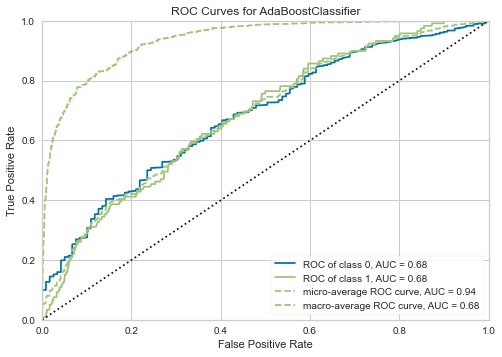

In [92]:
#visualizing the model
plot_model(ada, plot = 'auc')

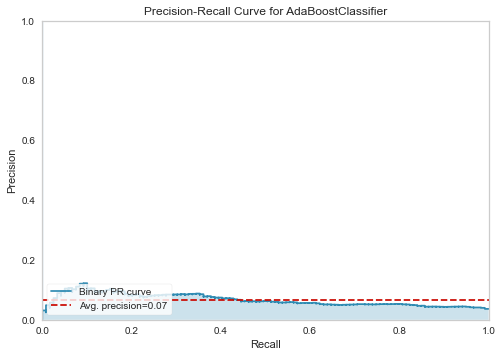

In [93]:
plot_model(tuned_ada, plot = 'pr')

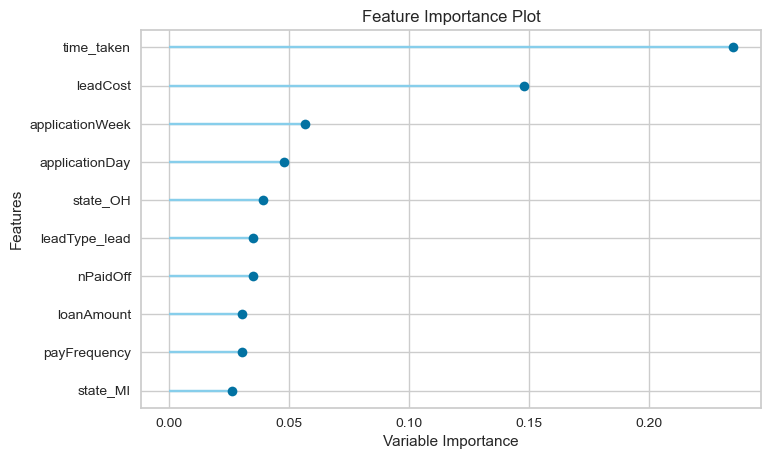

In [94]:
plot_model(tuned_ada, plot='feature')

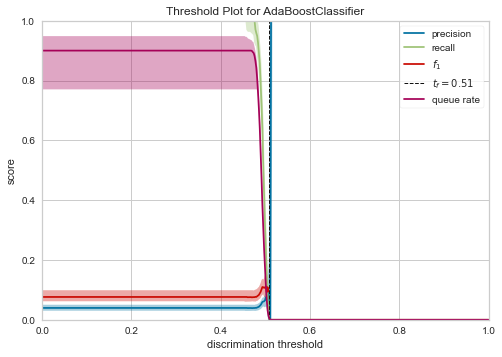

In [95]:
plot_model(tuned_ada, plot='threshold')

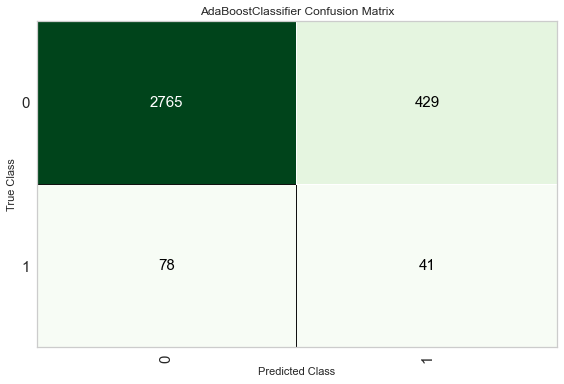

In [96]:
plot_model(ada, plot = 'confusion_matrix')

From the confusion matrix, TP = 41, TN= 2765, FN = 78, FP = 429
- out of 119 default loan, it detected 41 default loan.
- out of 3194 paid loan, it detected 2765 paid loan.

In [97]:
# interpret_model(lda)

In [98]:
predict_model(tuned_ada)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.8394,0.6693,0.3529,0.0845,0.1364,0.0832,0.1097


,state_FL,state_CA,state_NV,leadType_organic,state_NM,state_MN,leadType_prescreen,loanAmount,applicationDay,state_MS,...,state_AZ,state_UT,nPaidOff,state_TN,state_MO,apr,leadType_rc_returning,loanStatus,Label,Score
0,0,0,0,0,0,0,0,600.0,15.0,0,...,0,0,0.0,0,0,590.0,0,0,1,0.5003
1,0,0,0,0,0,0,0,1000.0,10.0,0,...,0,0,0.0,0,0,360.0,0,0,1,0.5045
2,0,0,0,0,0,0,0,800.0,18.0,0,...,0,0,0.0,0,0,601.0,0,0,0,0.5111
3,0,0,0,0,0,0,0,700.0,12.0,0,...,1,0,0.0,0,0,645.0,0,0,0,0.5076
4,0,0,0,0,0,0,0,1000.0,17.0,0,...,0,0,0.0,0,0,680.0,0,0,0,0.5150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,0,0,0,0,0,0,0,900.0,24.0,0,...,0,0,0.0,0,0,475.0,0,0,1,0.5047
3309,0,0,0,1,0,0,0,500.0,4.0,0,...,0,0,0.0,0,0,359.0,0,0,0,0.5167
3310,0,0,0,0,0,0,0,600.0,10.0,0,...,0,0,4.0,0,0,565.0,1,0,0,0.5034
3311,0,0,0,0,0,0,0,300.0,30.0,0,...,0,0,0.0,0,0,590.0,0,0,0,0.5131


In [99]:
#Finalized the model
# final_ada = finalize_model(tuned_ada)
final_ada = finalize_model(tuned_ada)

In [100]:
#ada - best machine learning model so far
df_pred = predict_model(final_ada, data=data_unseen)
get_model_performance(df_pred['loanStatus'], df_pred['Label'])

[[2316  357]
 [  59   28]]
Acc: 0.8492753623188406
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2673
           1       0.07      0.32      0.12        87

    accuracy                           0.85      2760
   macro avg       0.52      0.59      0.52      2760
weighted avg       0.95      0.85      0.89      2760

ROC_AUC: 0.5941406401176517


In [101]:
#save model for future use
save_model(final_ada,'finalada 18082021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['leadCost'],
                                       target='loanStatus', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None...
                  Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                     n_jobs=-1, random_state=123,
                                                     subclass='binary',
                                                     target='loanStatus'

In [102]:
# #load
# saved_final_ada = load_model('finalada 18082021')

## Since pycaret not satisfying, I decided to do manually, to see whether there's difference

In [140]:
# X_train, X_test, y_train, y_test = train_test_split(df_train.drop('loanStatus', axis=1), 
#                                                     df_train['loanStatus'], test_size=0.25, random_state=42)

#make the data used in pycaret same with here
X_train, y_train = data.drop('loanStatus', axis=1), data['loanStatus']
X_test, y_test = data_unseen.drop('loanStatus', axis=1), data_unseen['loanStatus']

In [141]:
y_test.value_counts()

0    2673
1      87
Name: loanStatus, dtype: int64

In [142]:
X_train

,payFrequency,apr,nPaidOff,loanAmount,leadCost,applicationWeek,applicationDay,clearfraudscore,earning_ratio,time_taken,...,state_UT,state_VA,state_WA,state_WI,state_other,leadType_lead,leadType_organic,leadType_other,leadType_prescreen,leadType_rc_returning
3698,3,501.50,2.0,546.0,0,42,18,0.0,2.601996,0.0,...,0,0,0,0,0,0,1,0,0,0
11190,3,199.00,0.0,3000.0,0,4,28,802.0,2.142700,0.0,...,0,0,0,0,0,0,0,0,1,0
6268,3,501.50,1.0,500.0,0,28,14,0.0,2.827300,4.0,...,0,0,0,0,0,0,1,0,0,0
845,3,625.00,0.0,350.0,3,48,28,731.0,2.940914,0.0,...,0,0,0,0,0,0,0,0,0,0
12200,3,449.99,2.0,750.0,0,51,14,829.0,1.779547,0.0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,3,390.00,0.0,300.0,10,22,27,719.0,2.230500,0.0,...,0,0,0,0,0,0,0,0,0,0
8046,2,590.00,0.0,1250.0,40,21,24,827.0,2.937064,0.0,...,0,0,0,0,0,1,0,0,0,0
11157,3,590.00,0.0,400.0,25,10,7,513.0,2.895225,7.0,...,0,0,0,0,0,1,0,0,0,0
4263,3,590.00,0.0,700.0,3,39,24,603.0,2.970229,0.0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
#try with simple logistic regression

log_class = LogisticRegression()
grid = {'C': 10.0**np.arange(-2,3), 'penalty':['l1', 'l2']}
cv = KFold(n_splits=5, random_state=None, shuffle=False)
clf = GridSearchCV(log_class, grid, cv=cv, scoring='f1')
log_class.fit(X_train, y_train)

y_pred = log_class.predict(X_test)
get_model_performance(y_test, y_pred)

[[2673    0]
 [  87    0]]
Acc: 0.9684782608695652
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2673
           1       0.00      0.00      0.00        87

    accuracy                           0.97      2760
   macro avg       0.48      0.50      0.49      2760
weighted avg       0.94      0.97      0.95      2760

ROC_AUC: 0.5


In [144]:
#let's try randomforest now (ensemble method baseline)
rf_clf =RandomForestClassifier()
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
get_model_performance(y_test, y_pred)

[[2671    2]
 [  87    0]]
Acc: 0.9677536231884057
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2673
           1       0.00      0.00      0.00        87

    accuracy                           0.97      2760
   macro avg       0.48      0.50      0.49      2760
weighted avg       0.94      0.97      0.95      2760

ROC_AUC: 0.4996258885147774


In [145]:
#now try to see whether class_weight can have diff results
class_weight = dict({0:1, 1:300}) #0 label weight 1, 1 label weight 300
rf_clf_w =RandomForestClassifier(class_weight=class_weight)
rf_clf_w.fit(X_train, y_train)

y_pred = rf_clf_w.predict(X_test)
get_model_performance(y_test, y_pred)

[[2673    0]
 [  87    0]]
Acc: 0.9684782608695652
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2673
           1       0.00      0.00      0.00        87

    accuracy                           0.97      2760
   macro avg       0.48      0.50      0.49      2760
weighted avg       0.94      0.97      0.95      2760

ROC_AUC: 0.5


In [146]:
#now lets try under sampling
ns=NearMiss(0.8) #0 is 1.25 more than 1 (y_train/0.8)
X_train_ns, y_train_ns = ns.fit_sample(X_train,y_train)
# y_train_ns.value_counts()
rf_clf_ns =RandomForestClassifier()
rf_clf_ns.fit(X_train_ns, y_train_ns)

y_pred = rf_clf_ns.predict(X_test)
get_model_performance(y_test, y_pred)

[[ 276 2397]
 [  12   75]]
Acc: 0.12717391304347825
              precision    recall  f1-score   support

           0       0.96      0.10      0.19      2673
           1       0.03      0.86      0.06        87

    accuracy                           0.13      2760
   macro avg       0.49      0.48      0.12      2760
weighted avg       0.93      0.13      0.18      2760

ROC_AUC: 0.48266186771933894


In [147]:
#now lets try oversampling
os = SMOTETomek(0.8)
X_train_uo, y_train_uo = os.fit_sample(X_train, y_train)
rf_clf_uo =RandomForestClassifier()
rf_clf_uo.fit(X_train_uo, y_train_uo)

y_pred = rf_clf_uo.predict(X_test)
get_model_performance(y_test, y_pred)

[[2636   37]
 [  83    4]]
Acc: 0.9565217391304348
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2673
           1       0.10      0.05      0.06        87

    accuracy                           0.96      2760
   macro avg       0.53      0.52      0.52      2760
weighted avg       0.94      0.96      0.95      2760

ROC_AUC: 0.5160674432705084


### Small conclusion: over sampling produce best result so far.
- if machine learning model like decision tree not suits, lets try simple deep learning.

In [148]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(len(X_train.columns), input_dim=len(X_train.columns), activation='relu'),
        keras.layers.Dense(len(X_train.columns)//2, activation='relu'),
        keras.layers.Dense(len(X_train.columns)//2, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    
    get_model_performance(y_test, y_pred)
    
    return y_pred

In [149]:
y_pred_baseline = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
346/346 [==============================] - 1s 2ms/step - loss: 0.3536 - accuracy: 0.9585
Epoch 2/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1812 - accuracy: 0.9623
Epoch 3/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1787 - accuracy: 0.9627
Epoch 4/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1705 - accuracy: 0.9633
Epoch 5/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1661 - accuracy: 0.9636
Epoch 6/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1621 - accuracy: 0.9632
Epoch 7/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1599 - accuracy: 0.9640
Epoch 8/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1562 - accuracy: 0.9638
Epoch 9/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1623 - accuracy: 0.9630
Epoch 10/100
346/346 [==============================] - 1s 2ms/step - loss: 0.1568 - accura

In [150]:
#under
y_pred_baseline = ANN(X_train_ns, y_train_ns, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
28/28 [==============================] - 0s 2ms/step - loss: 5.3841 - accuracy: 0.6570
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 1.3088 - accuracy: 0.8380
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.7705 - accuracy: 0.8670
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.8615
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.4560 - accuracy: 0.8704
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3931 - accuracy: 0.8704
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.8860
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3451 - accuracy: 0.8782
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3179 - accuracy: 0.8894
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3037 - accuracy: 0.8827
Epoch 11/

28/28 [==============================] - 0s 2ms/step - loss: 0.3022 - accuracy: 0.8972
Epoch 84/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.9128
Epoch 85/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2757 - accuracy: 0.9095
Epoch 86/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2860 - accuracy: 0.9061
Epoch 87/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3572 - accuracy: 0.8860
Epoch 88/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2708 - accuracy: 0.9050
Epoch 89/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2740 - accuracy: 0.8961
Epoch 90/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2959 - accuracy: 0.8983
Epoch 91/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2696 - accuracy: 0.9039
Epoch 92/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2640 - accuracy: 0.9061
Epoch 93/100


In [151]:
#over 
y_pred_baseline = ANN(X_train_uo, y_train_uo, X_test, y_test, 'binary_crossentropy', -1) #best in deep learning

Epoch 1/100
593/593 [==============================] - 1s 2ms/step - loss: 1.4743 - accuracy: 0.5710
Epoch 2/100
593/593 [==============================] - 1s 2ms/step - loss: 0.7271 - accuracy: 0.6172
Epoch 3/100
593/593 [==============================] - 1s 2ms/step - loss: 0.6730 - accuracy: 0.6450
Epoch 4/100
593/593 [==============================] - 1s 2ms/step - loss: 0.6025 - accuracy: 0.6781
Epoch 5/100
593/593 [==============================] - 1s 2ms/step - loss: 0.5746 - accuracy: 0.7059
Epoch 6/100
593/593 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.7303
Epoch 7/100
593/593 [==============================] - 1s 2ms/step - loss: 0.5064 - accuracy: 0.7607
Epoch 8/100
593/593 [==============================] - 1s 2ms/step - loss: 0.4862 - accuracy: 0.7674
Epoch 9/100
593/593 [==============================] - 1s 2ms/step - loss: 0.4666 - accuracy: 0.7796
Epoch 10/100
593/593 [==============================] - 1s 2ms/step - loss: 0.4682 - accura

In [159]:
#lets try whether PCA helps
X_train, y_train = data.drop('loanStatus', axis=1), data['loanStatus']
X_test, y_test = data_unseen.drop('loanStatus', axis=1), data_unseen['loanStatus']

pca = PCA(n_components=3) 
pca.fit(X_train)
print(pca.explained_variance_ratio_) #3 is enough as it explained 99%

[0.68320356 0.27326269 0.04055923]


In [160]:
X_train, X_test = pca.transform(X_train), pca.transform(X_test)

In [161]:
log_class = LogisticRegression()
log_class.fit(X_train, y_train)

y_pred = log_class.predict(X_test)
get_model_performance(y_test, y_pred)

[[2673    0]
 [  87    0]]
Acc: 0.9684782608695652
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2673
           1       0.00      0.00      0.00        87

    accuracy                           0.97      2760
   macro avg       0.48      0.50      0.49      2760
weighted avg       0.94      0.97      0.95      2760

ROC_AUC: 0.5


In [162]:
#let's try randomforest now (ensemble method baseline)
rf_clf =RandomForestClassifier()
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
get_model_performance(y_test, y_pred)

[[2660   13]
 [  85    2]]
Acc: 0.9644927536231884
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2673
           1       0.13      0.02      0.04        87

    accuracy                           0.96      2760
   macro avg       0.55      0.51      0.51      2760
weighted avg       0.94      0.96      0.95      2760

ROC_AUC: 0.5090625282196163


In [163]:
os = SMOTETomek(0.8) #actually with pca better there, but really not much
X_train_uo, y_train_uo = os.fit_sample(X_train, y_train)
rf_clf_uo =RandomForestClassifier()
rf_clf_uo.fit(X_train_uo, y_train_uo)

y_pred = rf_clf_uo.predict(X_test)
get_model_performance(y_test, y_pred)

[[2281  392]
 [  67   20]]
Acc: 0.8336956521739131
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      2673
           1       0.05      0.23      0.08        87

    accuracy                           0.83      2760
   macro avg       0.51      0.54      0.49      2760
weighted avg       0.94      0.83      0.88      2760

ROC_AUC: 0.5416166776320033


In [164]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(30, input_dim=len(X_train.columns), activation='relu'),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    
    get_model_performance(y_test, y_pred)
    
    return y_pred

In [165]:
#over - PCA doesn't help in deep learning
df_1 = pd.DataFrame(X_train_uo,columns=['pca1', 'pca2', 'pca3'])
df_2 = pd.DataFrame(X_test,columns=['pca1', 'pca2', 'pca3'])
y_pred_baseline = ANN(df_1, y_train_uo, df_2, y_test, 'binary_crossentropy', -1)

Epoch 1/100
550/550 [==============================] - 1s 2ms/step - loss: 1.0576 - accuracy: 0.5819
Epoch 2/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6704 - accuracy: 0.6168
Epoch 3/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6551 - accuracy: 0.6259
Epoch 4/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6408 - accuracy: 0.6254
Epoch 5/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6294 - accuracy: 0.6389
Epoch 6/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6255 - accuracy: 0.6374
Epoch 7/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6184 - accuracy: 0.6448
Epoch 8/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6172 - accuracy: 0.6455
Epoch 9/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6158 - accuracy: 0.6460
Epoch 10/100
550/550 [==============================] - 1s 2ms/step - loss: 0.6162 - accura

I think that since the models of machine learning&pycaret and deep learning doesn't provide any good results for me to further enhance, I think i will stop here.

# Conclusion:
1. All results are not satisfying.
    - The best model is ada boost with pycaret.
    - Based on the AUC, the highest is around 0.60, with macro F1-score of 0.52, which indicates that model just slightly better than guessing.
- The important features that the models suggest are:
    - I think its pointless since the models are not good

### Future works
- I guess its time to get more features and data, or change the target label.
    - Get more dataset (financial background, reason for applying, etc.) regarding the applicants to create a more sophisticated model.
    - Maybe can target who can tolerate settlement to prevent more loss? 


## References:

In [167]:
#model guide:
#https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36
#https://towardsdatascience.com/tuning-a-models-hyperparameters-and-aiming-for-a-specific-metric-in-accordance-with-the-business-3c47d534ed3b
#https://medium.com/dataman-in-ai/sampling-techniques-for-extremely-imbalanced-data-281cc01da0a8
#https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

#AUC ROC:
# https://medium.com/hiredscore-engineering/7-things-you-should-know-about-roc-auc-b4389ea2b2e3

#f1score is recommended.
#https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
#https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc << important

#imbalance model
#https://towardsdatascience.com/introduction-to-synthetic-minority-over-sampling-technique-and-its-implementation-from-scratch-77593647c10d

#macro micro
# https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

#read
# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/
# https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio